# Lab 5: Wide and Deep Networks

## Preparation

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read the data
data = 'healthcare-dataset-stroke-data.csv'
df = pd.read_csv(data)
print(df.shape)
df.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [2]:
# check for duplicates
df.duplicated().sum()

0

In [3]:
# drop id column
df = df.drop(['id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


The data is organized as follows:

|Variable | Description|
|---------|------------|
|gender| Male/Female|
|age| continuous|
|hypertension| 0=No, 1=Yes|
|heart_disease| 0=No, 1=Yes|
|ever_married| No/Yes|
|work_type| children, Govt_jov, Never_worked, Private, Self-employed|
|Residence_type| Rural/Urban|
|avg_glucose_level| continuous|
|bmi| continuous|
|smoking_status| formerly smoked, never smoked, smokes, Unknown|
|`stroke`| 0=No, 1=Yes|

In [4]:
categorical_headers = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease']
numerical_headers = ['age', 'avg_glucose_level', 'bmi']

In [5]:
# Check for missing values
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


BMI is the only column with missing values. 201/5110 ~= 3.93% of the rows don't have BMI; that's not a huge percentage, so we will use KNN imputation to fill in these values.

As a note, a large portion of the smoking values - almost 30% - are "unknown." We debated whether or not to treat this as essentially a NaN and drop or impute, but we decided to leave these rows in in case we discover later that the "unknown" values skew towards strokes or not. This could be because smokers may not want to answer that question and admit they smoke.

In [6]:
from sklearn.impute import KNNImputer
import copy

# Use k = 3 nearest neighbors based on age, bmi, and average glucose level
knn_obj = KNNImputer(n_neighbors=3) 
attributes_to_impute_with = ['age', 'bmi', 'avg_glucose_level']
temp = df[attributes_to_impute_with].to_numpy()
temp_imputed = knn_obj.fit_transform(temp)
df_imputed = copy.deepcopy(df)
df_imputed[attributes_to_impute_with] = temp_imputed
df_imputed.dropna(inplace=True)
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [7]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['stroke'])

# Check the distribution of the target variable in the train and test sets
# print the percentage of positive and negative examples in the train and test sets
print('Train set:')
print(df_train.shape)
print(df_train['stroke'].value_counts(normalize=True))
print('Test set:')
print(df_test.shape)
print(df_test['stroke'].value_counts(normalize=True))


Train set:
(4088, 11)
stroke
0    0.951321
1    0.048679
Name: proportion, dtype: float64
Test set:
(1022, 11)
stroke
0    0.951076
1    0.048924
Name: proportion, dtype: float64


# TODO: Oversample training data to account for class imbalance

increase number of people with strokes to 20% of the training data

In [8]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.13.0
2.13.1


In [149]:
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.layers import Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [195]:
# create a tensorflow dataset
batch_size = 64

def df_to_dataset(df, shuffle=True, batch_size=batch_size):
    df = df.copy()
    labels = df.pop('stroke')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

ds_train = df_to_dataset(df_imputed)
ds_test = df_to_dataset(df_test, shuffle=False)

In [168]:
# print out the data type of each feature
for feature_batch, label_batch in ds_train.take(1):
    print('Every feature:', list(feature_batch.keys()))
    # print feature datatype
    print('Feature shape for age is:', feature_batch['age'].shape)
    print('Max:', max(feature_batch['age']))

Every feature: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
Feature shape for age is: (64,)
Max: tf.Tensor(82.0, shape=(), dtype=float64)


#### Cross-Product Features

Our categorical features are gender, hypertension, heart_disease, ever_married, work_type, and Residence_type. hypertension and heart_disease are already encoded as integers; the other five are strings. When building a keras feature space, we need to consider which categories make sense to combine into cross-product features. After working with this dataset in lab 1, we believe the following combinations should be made:

#### TODO: We are discretizing age so we can include in crossing, correct? If not, just do hypertension and heart disease. **You are correct**

- **age, hypertension, heart_disease:** Age is the highest correlating risk factor for stroke. The median age for a stroke patient in our dataset is 70. This means that anyone at that age or above should certainly be screened. Additionally, hypertension and heart disease are serious underlying health conditions. They both serve individually as strong risk factors for stroke, and the combination of the two is an even greater risk factor. Age also correlates strongly with hypertension and heart disease, so we believe it makes sense to include them in a cross-product with age. In lab 1, we found that an alarming 25% of patients with both conditions suffered from a stroke. We definitely want to memorize this combination.
- **ever_married, Residence_type, work_type:** The three "lifestyle" attributes make sense to combine. The lifestyle attributes likely contribute to a person's stress levels. [According to the Heart and Stroke Foundation of Canada](https://www.heartandstroke.ca/healthy-living/reduce-stress/stress-basics), stress levels increase the likelihood for strokes and increase the underlying risk factors for strokes, such as hypertension. Again, in lab 1, we saw that certain combinations of the lifestyle attributes resulted in positive stroke diagnoses at a rate higher than the general population (which is about 5%). 


In [283]:
from tensorflow.keras.utils import FeatureSpace


# Create the feature space with preprocessing steps applied and crossed features
feature_space = FeatureSpace(
    features={

        # Categorical features encoded as string
        'gender': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'ever_married': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'work_type': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'Residence_type': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'smoking_status': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),

        # Numerical features
        'age': FeatureSpace.float_discretized(num_bins=10),

        # Numerical features to normalize
        'avg_glucose_level': FeatureSpace.float_normalized(),
        'bmi': FeatureSpace.float_normalized(),

        # Categorical features encoded as integers
        'hypertension': FeatureSpace.integer_categorical(num_oov_indices=0),
        'heart_disease': FeatureSpace.integer_categorical(num_oov_indices=0),
    },
    crosses=[
        # Is 10 a crossing dimension for age if there are 10 bins?
        # Can we do this while initializing the feature space?
        # Or Should age be excluded?
        FeatureSpace.cross(feature_names=('age', 'hypertension', 'heart_disease'), crossing_dim=10*2*2, output_mode='int'), 
        FeatureSpace.cross(feature_names=('ever_married', 'Residence_type', 'work_type'), crossing_dim=2*2*5, output_mode='int'), 
    ],
    output_mode='dict',
)

# Create a version of the dataset without labels
train_ds_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_no_labels)
preprocessed_ds_train = ds_train.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_train = preprocessed_ds_train.prefetch(tf.data.AUTOTUNE)

preprocessed_ds_test = ds_test.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_test = preprocessed_ds_test.prefetch(tf.data.AUTOTUNE)

2023-11-09 20:31:28.200245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 20:31:28.394933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 20:31:28.593425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 20:31:28.795177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 20:31:29.011372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 20:31:29.268232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 20:31:29.285092: I tensorflow/core/grappler/optimizers/cust

### Evaluation Metric

Our evaluation metric of choice will be F-beta with a larger beta value. For stroke risk classification, we want to minimize the number of false negatives as much as possible. Consider the following two scenarios:

- **False positive:** a patient is at low risk, but we classify them as high risk. This means that a patient may undergo unecessary treatment, expenses, and stress if they are screened to visit a doctor, believing they are at high risk for a stroke. However, ultimately the patient is unlikley to suffer from a stroke, so they are still safer despite the false positive.
- **False negative:** a patient is at high risk, but we classify them as low risk. This means that a patient falsely believes they are at low risk for a stroke. In this case, key warning signs could go undetected or ignored, and a patient may suffer a stroke without expecting one at all. They would require emergency care, and potentially suffer the most severe consequence possible: death.

False negatives and false positives are both bad; however, false negatives are clearly worse. As such, we need an evaluation metric that will tell us if our model is good at avoiding false negatives, while still doing our best to avoid false positives. F-beta can accomplish that for us; if we make beta greater than 1, the addition of the beta term in the denominator weighs recall more importantly than precision. This is what we're looking for. 

#### Data Divison Method

When it comes to dividing our data into training and testing, we feel that **stratified k-fold cross validation** makes the most sense. There is a large class imbalance present in our dataset; only approximately 5% (250/5110) of patients actually suffered a stroke, and 95% of patients did not. Using stratified k-fold cross validation will allow for each fold to mirror the original class imbalance present in the dataset. If we were to use non-stratified cross validation or shuffle splits, given the large class imbalance, it's very likely that getting randomized train and test folds could result in 100% non-stroke patients in the fold, which would make for a poor model when it comes to testing. If the model hasn't seen positive stroke patients, it won't know how to classify them. We want to make sure that each fold sees at least a few positive stroke patients. Additionally, given that we only have a moderately sized dataset at 5000 instances, dividing our dataset into training and testing folds will allow us to reuse the data multiple times, instead of trying to generate synthetic samples which could induce noise. In addition, we can take metrics on every iteration of the cross validation process, and then average them or calculate the standard deviation to understand how our model performs across different folds and bound our expectations of it. 

This is a realistic method to use because in many real-world medical applications, including stroke risk prediction, datasets tend to be imbalanced, with a smaller number of high-risk cases compared to low-risk cases. Using stratified k-fold cross validation to mirror this reality allows us to view how our model would perform on these underrepresented, high-risk cases.


In [13]:
# TODO: Use this methodology when actually running the model.

# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.metrics import fbeta_score

# clf = training_model
# cv = StratifiedKFold(n_splits=10)
# scorer = make_scorer(fbeta_score, beta=2)
# per_fold_eval_criteria = cross_val_score(estimator=clf, X=preprocessed_ds, y=y, cv=cv, scoring=scorer)

In [170]:
def setup_embedding_from_encoding(encoded_features, col_name):
    # what the maximum integer value for this variable?
    
    # get the size of the feature
    x = encoded_features[col_name]
    N = x.shape[1]
    
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x

### Wide and Deep Network #1 

Model: "model_75"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_591 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_589 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_595 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_584 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                           

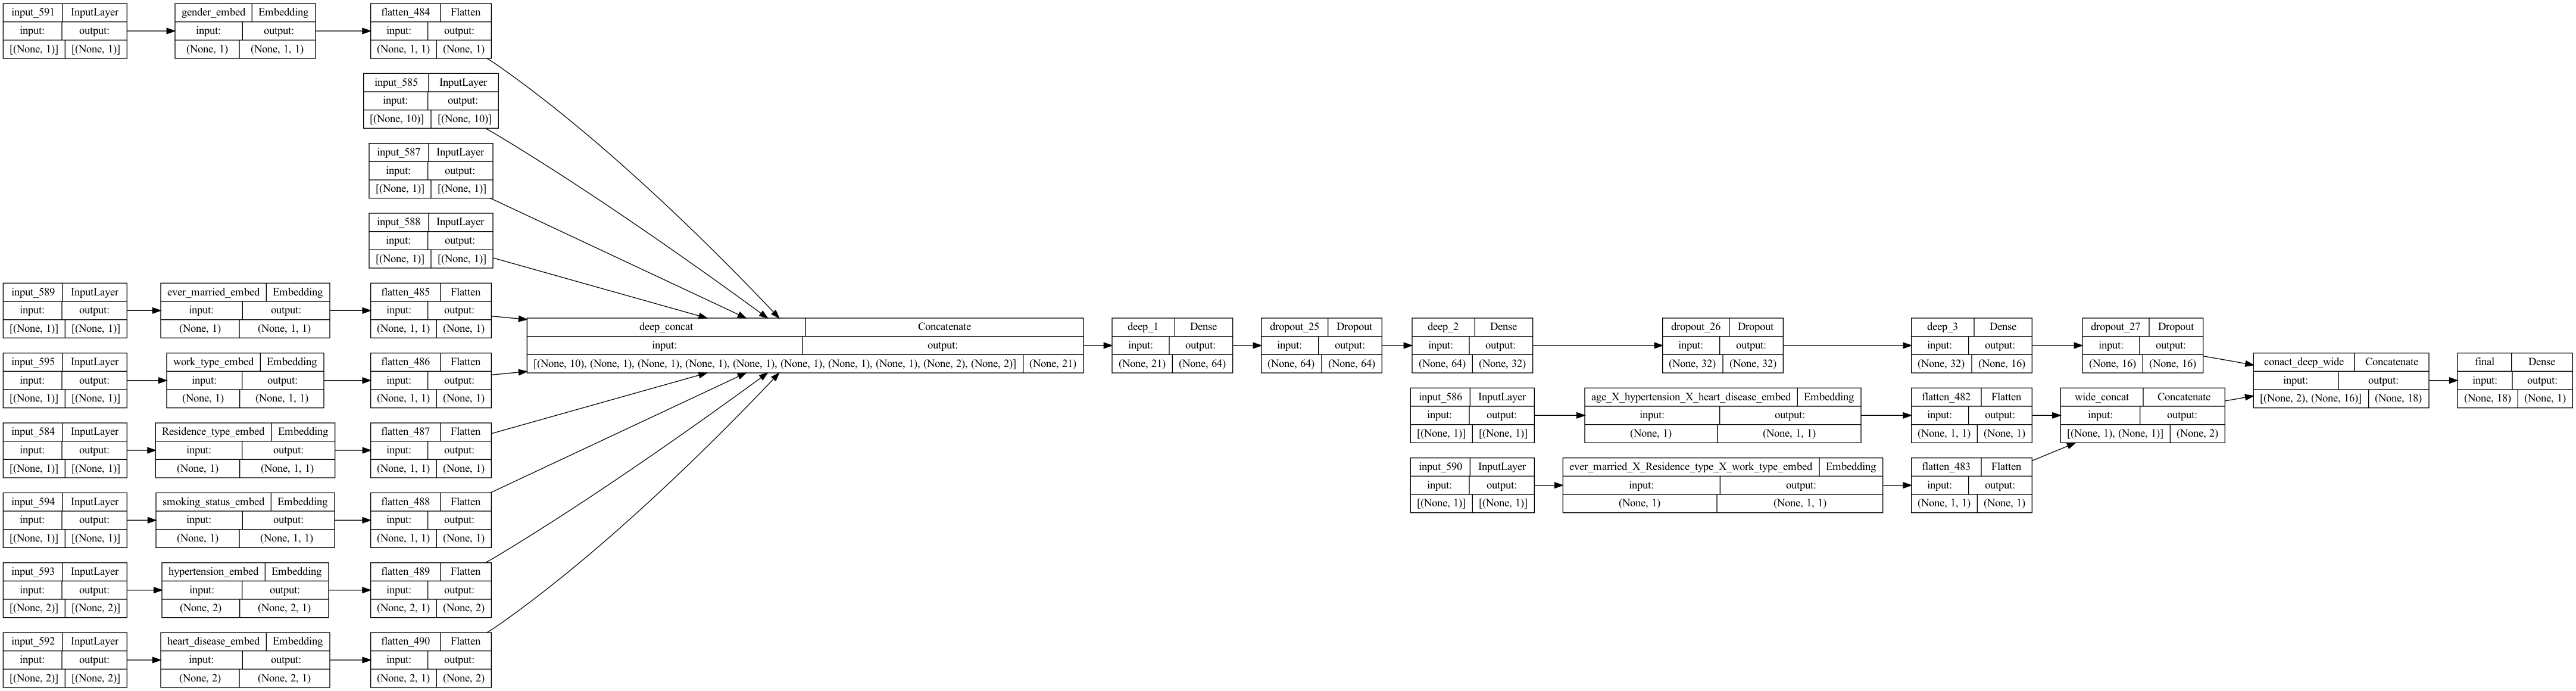

In [191]:
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.metrics import Precision, Recall, AUC

dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
encoded_features = feature_space.get_encoded_features() # these features have been encoded

crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():
    
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs.append(x)

wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

all_deep_branch_outputs = []

for col in numerical_headers:
    x = encoded_features[col]
    # x = tf.cast(x,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)

deep_branch = Concatenate(name='deep_concat')(all_deep_branch_outputs)
deep_branch = Dense(64, activation='relu', name='deep_1')(deep_branch)
deep_branch = Dense(32, activation='relu', name='deep_2')(deep_branch)
deep_branch = Dense(16, activation='relu', name='deep_3')(deep_branch)

final_branch = Concatenate(name='conact_deep_wide')([wide_branch, deep_branch])
final_branch = Dense(1, activation='sigmoid', name='final')(final_branch)

training_model_network1 = Model(inputs=encoded_features, outputs=final_branch)
training_model_network1.compile(optimizer='adam', loss='binary_crossentropy', 
                    metrics=[
                        'accuracy', 
                        Precision(name='precision'),
                        Recall(name='recall'),
                        AUC(name='auc')])

training_model_network1.summary()

plot_model(
    training_model_network1, show_shapes=True, show_layer_names=True, to_file='model.png',
    rankdir='LR', expand_nested=False, dpi=96
)

In [198]:
network1_history = training_model_network1.fit(preprocessed_ds_train, epochs=10, validation_data=preprocessed_ds_test, verbose=2)

Epoch 1/10
80/80 - 13s - loss: 0.3423 - accuracy: 0.8716 - precision: 0.1293 - recall: 0.2851 - auc: 0.7191 - val_loss: 0.1874 - val_accuracy: 0.9501 - val_precision: 0.4000 - val_recall: 0.0400 - val_auc: 0.7951 - 13s/epoch - 160ms/step
Epoch 2/10
80/80 - 4s - loss: 0.2016 - accuracy: 0.9434 - precision: 0.1552 - recall: 0.0361 - auc: 0.7046 - val_loss: 0.1731 - val_accuracy: 0.9501 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8026 - 4s/epoch - 49ms/step
Epoch 3/10
80/80 - 3s - loss: 0.1873 - accuracy: 0.9460 - precision: 0.2128 - recall: 0.0402 - auc: 0.7400 - val_loss: 0.1719 - val_accuracy: 0.9501 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7960 - 3s/epoch - 40ms/step
Epoch 4/10
80/80 - 3s - loss: 0.1786 - accuracy: 0.9476 - precision: 0.1724 - recall: 0.0201 - auc: 0.7665 - val_loss: 0.1685 - val_accuracy: 0.9511 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8068 - 3s/epoch - 38ms/step
Epoch 5/10
80/80 - 3s - loss: 0.1

In [204]:
# calculate f1 beta score
F1_beta_training = []
F1_beta_validation = []
beta=2
for i in range(len(network1_history.history['precision'])):
    F1_beta = (1+beta**2) * (network1_history.history['precision'][i] * network1_history.history['recall'][i]) / ((beta**2 * network1_history.history['precision'][i]) + network1_history.history['recall'][i])
    F1_beta_training.append(F1_beta)
    # can't calculate validation F1 beta score because recall is 0
    # F1_beta = (1+beta**2) * (network1_history.history['val_precision'][i] * network1_history.history['val_recall'][i]) / ((beta**2 * network1_history.history['val_precision'][i]) + network1_history.history['val_recall'][i])
    # F1_beta_validation.append(F1_beta)

print('F1 beta score training: ', F1_beta_training)

F1 beta score:  [0.22977346771117785, 0.0426944955573714, 0.04793863688235246, 0.024390243031877906, 0.014720313494068405, 0.024509803016241446, 0.024461838653369147, 0.024414061631290448, 0.03411306139358301, 0.029268291650181504]


In [223]:
# create a function to calculate the F1 beta score
def calculate_F1_beta(percision_list, recall_list, beta):
    F1_beta_list = []
    for i in range(len(percision_list)):
        F1_beta = (1+beta**2) * (percision_list[i] * recall_list[i]) / ((beta**2 * percision_list[i]) + recall_list[i])
        F1_beta_list.append(F1_beta)
    return F1_beta_list


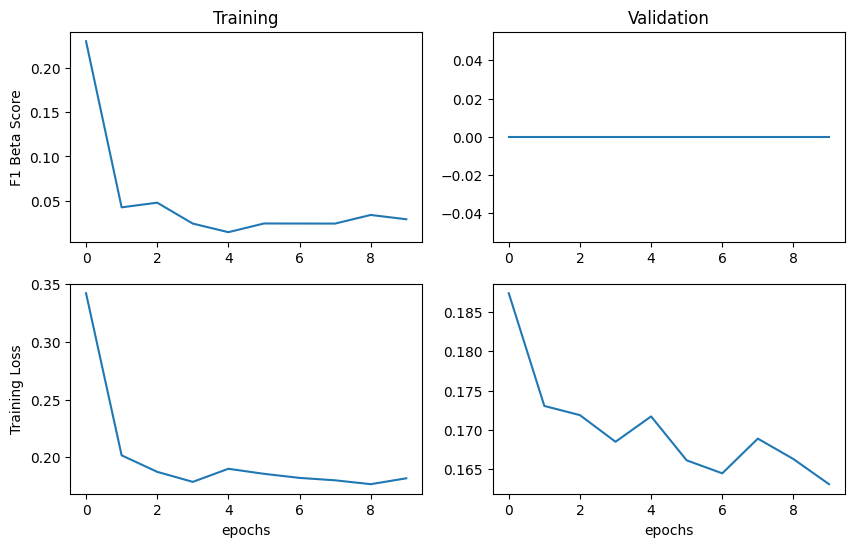

In [212]:
# Plot the training and validation loss and f1 beta score

# loss
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(F1_beta_training)

plt.ylabel('F1 Beta Score')
plt.title('Training')
plt.subplot(2, 2, 2)
plt.plot([0]*10)
plt.title('Validation')

plt.subplot(2, 2, 3)
plt.plot(network1_history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2, 2, 4)
plt.plot(network1_history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

As you can see here, the accuracy is incredibly high because the model is overfitting the dataset. This is because the dataset is very imbalanced, with only 5% of the data being positive stroke cases. We can't even use the F1 beta metric to measure the validation score because the recall is 0 for some of the epochs. As such, the model is able to achieve high accuracy by simply predicting that every case is negative. This is not a good model, and we need to find a way to improve it.

Combat the imbalanced dataset we over sampled the positive stroke cases to 35% of the training data. This is a realistic method to use because in many real-world medical applications, including stroke risk prediction, datasets tend to be imbalanced, with a smaller number of high-risk cases compared to low-risk cases.

In [218]:
# oversample the training set so that the percentage of positive examples is 20%
from imblearn.over_sampling import RandomOverSampler

# Assuming 'df_train' is your training dataset
# Assuming 'Stroke' is your label column

# Separate features and labels
X_train = df_train.drop('stroke', axis=1)
y_train = df_train['stroke']

# Calculate the ratio you want after oversampling (e.g., 20%)
desired_positive_ratio = 0.35

# Count the number of positive and negative examples
positive_count = sum(y_train == 1)
negative_count = sum(y_train == 0)

# Calculate the number of positive examples needed to achieve the desired ratio
desired_positive_count = int(desired_positive_ratio * negative_count / (1 - desired_positive_ratio))

# Create the RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy={1: desired_positive_count})

# Fit and transform the training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Combine the resampled features and labels into a new DataFrame
df_train_resampled = pd.concat([pd.DataFrame(X_train_resampled, columns=X_train.columns), pd.Series(y_train_resampled, name='stroke')], axis=1)

# Verify the new distribution
print(df_train_resampled['stroke'].value_counts(normalize=True))


stroke
0    0.650008
1    0.349992
Name: proportion, dtype: float64


In [219]:
ds_train = df_to_dataset(df_train_resampled)

In [220]:
from tensorflow.keras.utils import FeatureSpace


# Create the feature space with preprocessing steps applied and crossed features
feature_space = FeatureSpace(
    features={

        # Categorical features encoded as string
        'gender': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'ever_married': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'work_type': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'Residence_type': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'smoking_status': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),

        # Numerical features
        'age': FeatureSpace.float_discretized(num_bins=10),

        # Numerical features to normalize
        'avg_glucose_level': FeatureSpace.float_normalized(),
        'bmi': FeatureSpace.float_normalized(),

        # Categorical features encoded as integers
        'hypertension': FeatureSpace.integer_categorical(num_oov_indices=0),
        'heart_disease': FeatureSpace.integer_categorical(num_oov_indices=0),
    },
    crosses=[
        # Is 10 a crossing dimension for age if there are 10 bins?
        # Can we do this while initializing the feature space?
        # Or Should age be excluded?
        FeatureSpace.cross(feature_names=('age', 'hypertension', 'heart_disease'), crossing_dim=10*2*2, output_mode='int'), 
        FeatureSpace.cross(feature_names=('ever_married', 'Residence_type', 'work_type'), crossing_dim=2*2*5, output_mode='int'), 
    ],
    output_mode='dict',
)

# Create a version of the dataset without labels
train_ds_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_no_labels)
preprocessed_ds_train = ds_train.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_train = preprocessed_ds_train.prefetch(tf.data.AUTOTUNE)

preprocessed_ds_test = ds_test.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_test = preprocessed_ds_test.prefetch(tf.data.AUTOTUNE)

2023-11-09 19:25:05.950406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:25:06.154414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:25:06.345398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:25:06.534056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:25:06.716257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:25:06.920683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:25:06.933750: I tensorflow/core/grappler/optimizers/cust

In order to enhance the generalization performance of our neural network model, we introduced dropout as a regularization technique. The primary goal was to address potential overfitting issues and promote a more robust model that performs well on new, unseen data.

Model: "model_77"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_615 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_613 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_619 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_608 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                           

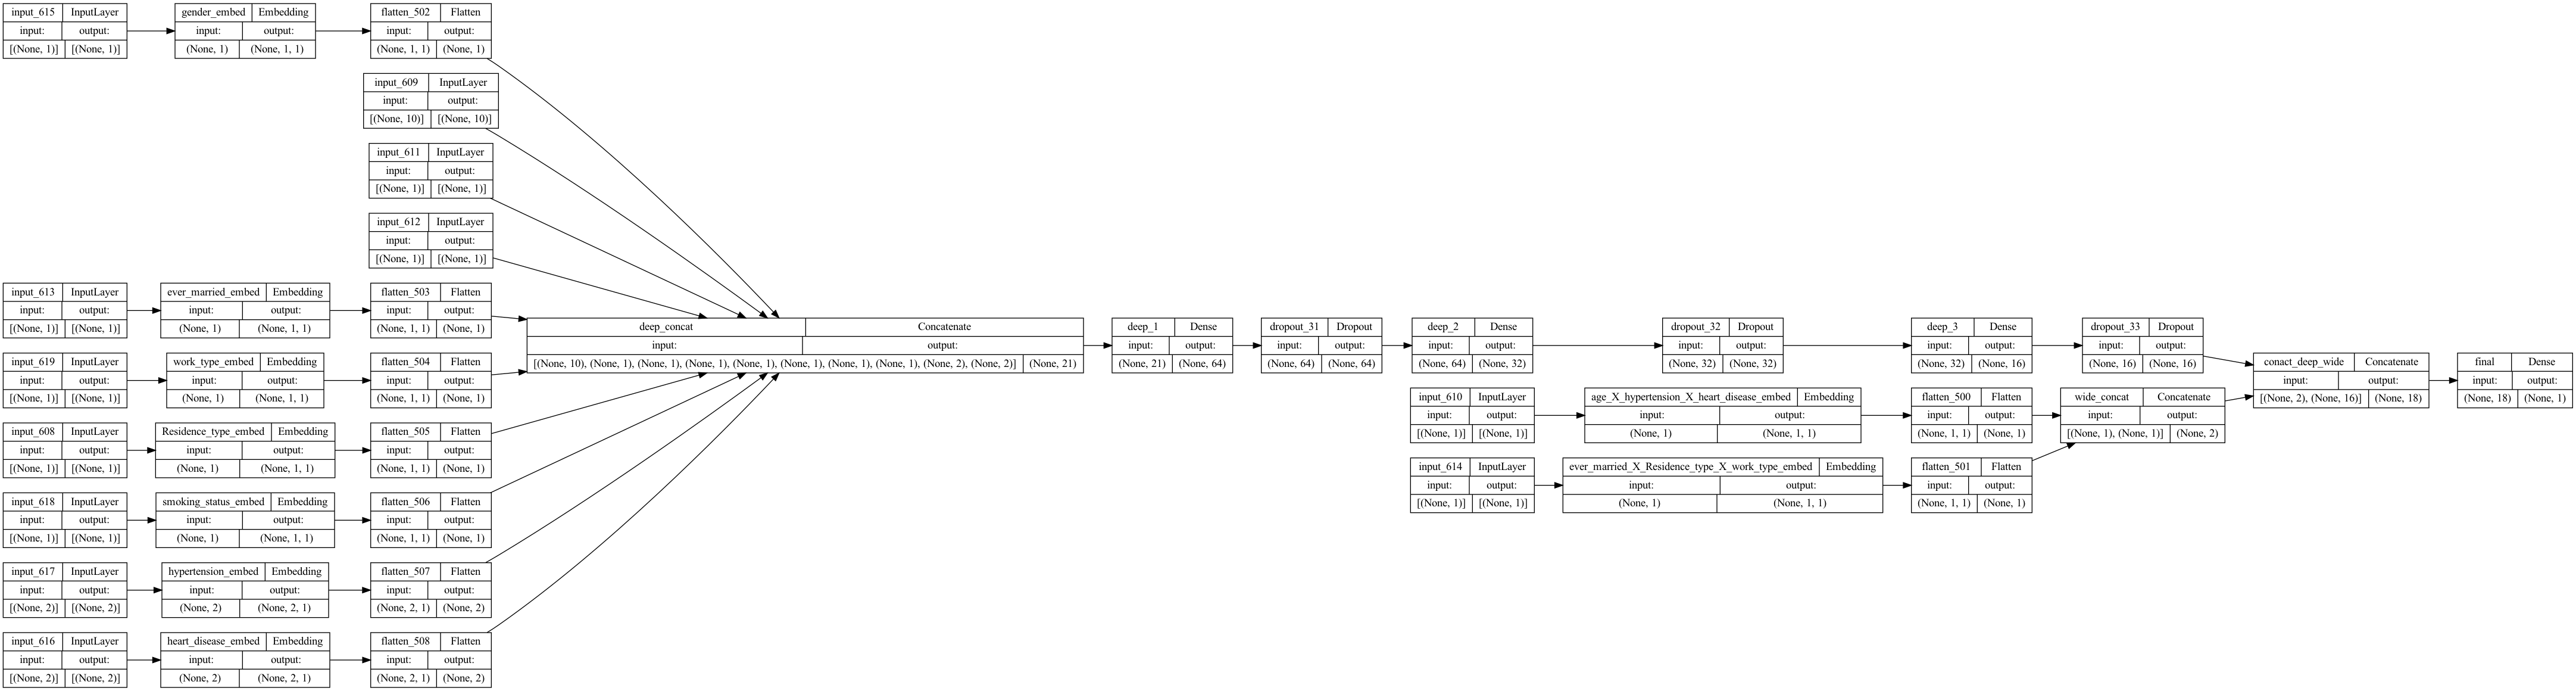

In [221]:
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.metrics import Precision, Recall, AUC

dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
encoded_features = feature_space.get_encoded_features() # these features have been encoded

crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():
    
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs.append(x)

wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

all_deep_branch_outputs = []

for col in numerical_headers:
    x = encoded_features[col]
    # x = tf.cast(x,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)

deep_branch = Concatenate(name='deep_concat')(all_deep_branch_outputs)
deep_branch = Dense(64, activation='relu', name='deep_1')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)
deep_branch = Dense(32, activation='relu', name='deep_2')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)
deep_branch = Dense(16, activation='relu', name='deep_3')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)

final_branch = Concatenate(name='conact_deep_wide')([wide_branch, deep_branch])
final_branch = Dense(1, activation='sigmoid', name='final')(final_branch)

training_model_network1 = Model(inputs=encoded_features, outputs=final_branch)
training_model_network1.compile(optimizer='adam', loss='binary_crossentropy', 
                    metrics=[
                        'accuracy', 
                        Precision(name='precision'),
                        Recall(name='recall'),
                        AUC(name='auc')])

training_model_network1.summary()

plot_model(
    training_model_network1, show_shapes=True, show_layer_names=True, to_file='model.png',
    rankdir='LR', expand_nested=False, dpi=96
)

In [222]:
network1_history = training_model_network1.fit(preprocessed_ds_train, epochs=10, validation_data=preprocessed_ds_test, verbose=2)

Epoch 1/10


2023-11-09 19:25:24.841790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:26:04.834753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 - 51s - loss: 0.5763 - accuracy: 0.6956 - precision: 0.5792 - recall: 0.4766 - auc: 0.7325 - val_loss: 0.3983 - val_accuracy: 0.8405 - val_precision: 0.1657 - val_recall: 0.5600 - val_auc: 0.8630 - 51s/epoch - 548ms/step
Epoch 2/10
94/94 - 5s - loss: 0.5178 - accuracy: 0.7364 - precision: 0.6240 - recall: 0.6213 - auc: 0.8015 - val_loss: 0.3772 - val_accuracy: 0.8180 - val_precision: 0.1531 - val_recall: 0.6000 - val_auc: 0.8528 - 5s/epoch - 49ms/step
Epoch 3/10
94/94 - 4s - loss: 0.5256 - accuracy: 0.7312 - precision: 0.6215 - recall: 0.5936 - auc: 0.7991 - val_loss: 0.3606 - val_accuracy: 0.8151 - val_precision: 0.1643 - val_recall: 0.6800 - val_auc: 0.8512 - 4s/epoch - 47ms/step
Epoch 4/10
94/94 - 4s - loss: 0.5862 - accuracy: 0.7157 - precision: 0.5937 - recall: 0.5946 - auc: 0.7803 - val_loss: 0.3002 - val_accuracy: 0.8464 - val_precision: 0.1758 - val_recall: 0.5800 - val_auc: 0.8522 - 4s/epoch - 40ms/step
Epoch 5/10
94/94 - 4s - loss: 0.6767 - accuracy: 0.7093 - precision:

In [255]:
F1_beta_training = calculate_F1_beta(network1_history.history['precision'], network1_history.history['recall'], 10)
F1_beta_validation = calculate_F1_beta(network1_history.history['val_precision'], network1_history.history['val_recall'], 10)

print('F1 beta score training: ', F1_beta_training[-1])
print('F1 beta score validation: ', F1_beta_validation[-1])

F1 beta score training:  0.5496325333434133
F1 beta score validation:  0.528488392731503


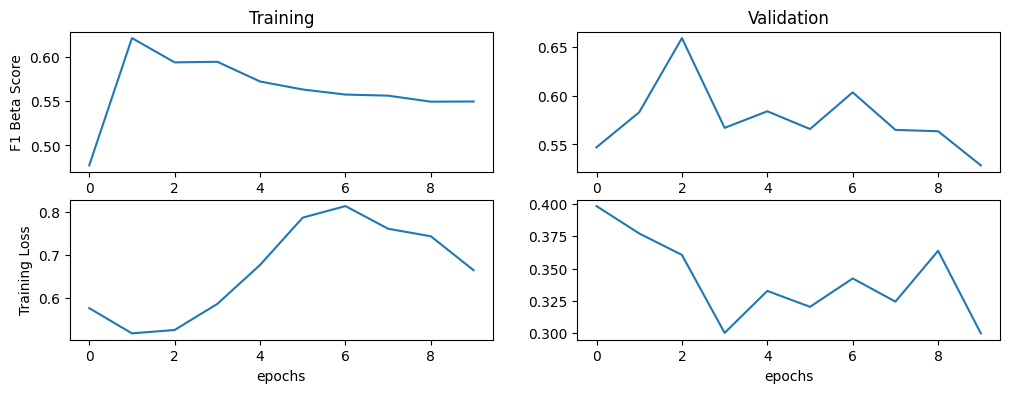

In [256]:
# Plot the training and validation accuracy and loss at each epoch

plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(F1_beta_training)

plt.ylabel('F1 Beta Score')
plt.title('Training')
plt.subplot(2, 2, 2)
plt.plot(F1_beta_validation)
plt.title('Validation')

plt.subplot(2, 2, 3)
plt.plot(network1_history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2, 2, 4)
plt.plot(network1_history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

### Wide and Deep Network #2

The difference in this network is we made it wider by keeping the numerica and categorical data separate and then put them each through one dense layer. Then we combined them and put them through more dense layers.

Model: "model_79"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_639 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_637 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_643 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_632 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                           

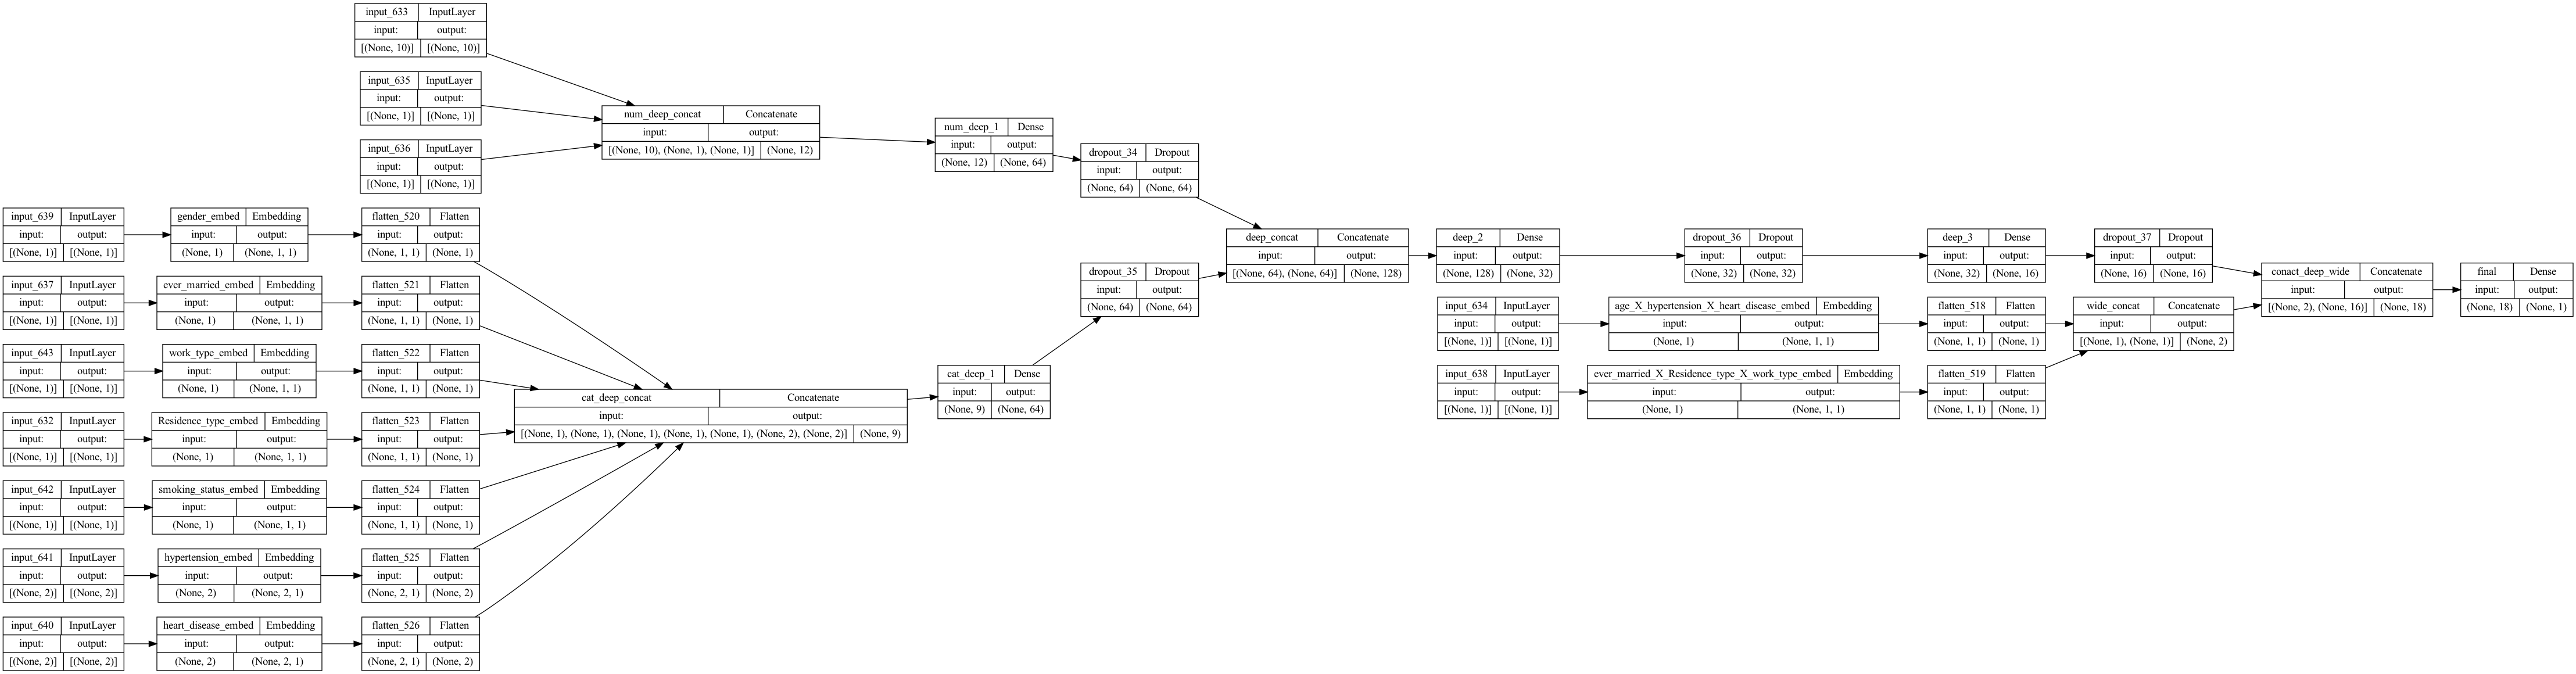

In [227]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
encoded_features = feature_space.get_encoded_features() # these features have been encoded

crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():
    
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs.append(x)

wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

numeric_deep_branch_outputs = []
categorical_deep_branch_outputs = []

for col in numerical_headers:
    x = encoded_features[col]
    #x = tf.cast(x,float) # cast an integer as a float here
    numeric_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    categorical_deep_branch_outputs.append(x)

num_deep_branch = Concatenate(name='num_deep_concat')(numeric_deep_branch_outputs)
num_deep_branch = Dense(64, activation='relu', name='num_deep_1')(num_deep_branch)
num_deep_branch = Dropout(0.2)(num_deep_branch)

cat_deep_branch = Concatenate(name='cat_deep_concat')(categorical_deep_branch_outputs)
cat_deep_branch = Dense(64, activation='relu', name='cat_deep_1')(cat_deep_branch)
cat_deep_branch = Dropout(0.2)(cat_deep_branch)

deep_branch = Concatenate(name='deep_concat')([num_deep_branch, cat_deep_branch])
deep_branch = Dense(32, activation='relu', name='deep_2')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)
deep_branch = Dense(16, activation='relu', name='deep_3')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)

final_branch = Concatenate(name='conact_deep_wide')([wide_branch, deep_branch])
final_branch = Dense(1, activation='sigmoid', name='final')(final_branch)

training_model_network2 = Model(inputs=encoded_features, outputs=final_branch)
training_model_network2.compile(optimizer='adam', loss='binary_crossentropy', 
                    metrics=[
                        'accuracy', 
                        Precision(name='precision'),
                        Recall(name='recall'),
                        AUC(name='auc')])

training_model_network2.summary()

plot_model(
    training_model_network2, show_shapes=True, show_layer_names=True, to_file='model.png',
    rankdir='LR', expand_nested=False, dpi=96
)

In [228]:
network2_history = training_model_network2.fit(preprocessed_ds_train, epochs=10, validation_data=preprocessed_ds_test, verbose=2)

Epoch 1/10


2023-11-09 19:32:22.714895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:33:05.265105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 - 55s - loss: 0.5763 - accuracy: 0.6976 - precision: 0.5971 - recall: 0.4183 - auc: 0.7303 - val_loss: 0.3670 - val_accuracy: 0.8356 - val_precision: 0.1648 - val_recall: 0.5800 - val_auc: 0.8351 - 55s/epoch - 585ms/step
Epoch 2/10
94/94 - 5s - loss: 0.5029 - accuracy: 0.7516 - precision: 0.6588 - recall: 0.6022 - auc: 0.8109 - val_loss: 0.3755 - val_accuracy: 0.8141 - val_precision: 0.1602 - val_recall: 0.6600 - val_auc: 0.8482 - 5s/epoch - 52ms/step
Epoch 3/10
94/94 - 4s - loss: 0.4967 - accuracy: 0.7434 - precision: 0.6411 - recall: 0.6065 - auc: 0.8155 - val_loss: 0.3524 - val_accuracy: 0.8249 - val_precision: 0.1551 - val_recall: 0.5800 - val_auc: 0.8448 - 4s/epoch - 44ms/step
Epoch 4/10
94/94 - 4s - loss: 0.4856 - accuracy: 0.7588 - precision: 0.6619 - recall: 0.6356 - auc: 0.8249 - val_loss: 0.3717 - val_accuracy: 0.8229 - val_precision: 0.1641 - val_recall: 0.6400 - val_auc: 0.8435 - 4s/epoch - 41ms/step
Epoch 5/10
94/94 - 4s - loss: 0.4903 - accuracy: 0.7463 - precision:

In [343]:
F1_beta_training = calculate_F1_beta(network2_history.history['precision'], network2_history.history['recall'], 10)
F1_beta_validation = calculate_F1_beta(network2_history.history['val_precision'], network2_history.history['val_recall'], 10)

print('F1 beta score training: ', F1_beta_training[-1])
print('F1 beta score validation: ', F1_beta_validation[-1])

F1 beta score training:  0.6173687424634541
F1 beta score validation:  0.6597502477196086


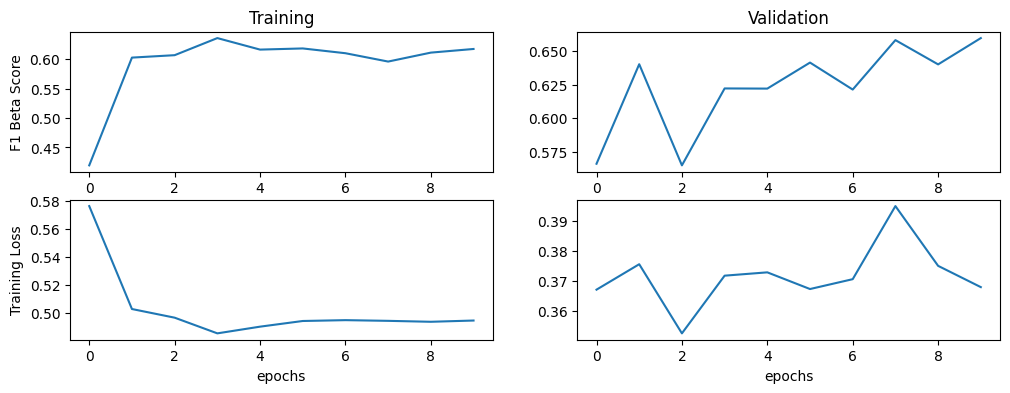

In [344]:
# Plot the training and validation accuracy and loss at each epoch

plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(F1_beta_training)

plt.ylabel('F1 Beta Score')
plt.title('Training')
plt.subplot(2, 2, 2)
plt.plot(F1_beta_validation)
plt.title('Validation')

plt.subplot(2, 2, 3)
plt.plot(network2_history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2, 2, 4)
plt.plot(network2_history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

### Wide and Deep Network #3

The difference in this network is we decided to cross-product all our cateogrical features into one cross. We decided to do this because we didn't have a lot of categorical features plus this would cacpture all the interactions between the features in one go.

In [240]:
# Create the feature space with preprocessing steps applied and crossed features
feature_space_2 = FeatureSpace(
    features={

        # Categorical features encoded as string
        'gender': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'ever_married': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'work_type': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'Residence_type': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'smoking_status': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),

        # Numerical features
        'age': FeatureSpace.float_discretized(num_bins=5),

        # Numerical features to normalize
        'avg_glucose_level': FeatureSpace.float_normalized(),
        'bmi': FeatureSpace.float_normalized(),

        # Categorical features encoded as integers
        'hypertension': FeatureSpace.integer_categorical(num_oov_indices=0),
        'heart_disease': FeatureSpace.integer_categorical(num_oov_indices=0),
    },
    crosses=[
        # create cross feature for all categorical features
        FeatureSpace.cross(feature_names=('gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'age',
                            'hypertension', 'heart_disease'), crossing_dim=3*2*5*2*4*2*2*5, output_mode='int'),
        # FeatureSpace.cross(feature_names=('age', 'hypertension', 'heart_disease'), crossing_dim=10*2*2, output_mode='int'), 
        # FeatureSpace.cross(feature_names=('ever_married', 'Residence_type', 'work_type'), crossing_dim=2*2*5, output_mode='int'),
        # FeatureSpace.cross(feature_names=('smoking_status', 'gender'), crossing_dim=5*2, output_mode='int'),
    ],
    output_mode='dict',
)

# Create a dataset with the feature space
train_ds_no_labels_2 = ds_train.map(lambda x, _: x)
feature_space_2.adapt(train_ds_no_labels_2)
preprocessed_ds_train_2 = ds_train.map(lambda x, y: (feature_space_2(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_train_2 = preprocessed_ds_train_2.prefetch(tf.data.AUTOTUNE)

preprocessed_ds_test_2 = ds_test.map(lambda x, y: (feature_space_2(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_test_2 = preprocessed_ds_test_2.prefetch(tf.data.AUTOTUNE)

2023-11-09 19:42:33.632746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:42:33.848323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:42:34.039773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:42:34.239221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:42:34.478129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:42:34.693932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:42:34.708340: I tensorflow/core/grappler/optimizers/cust

Model: "model_81"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_660 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_659 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_665 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_655 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                           

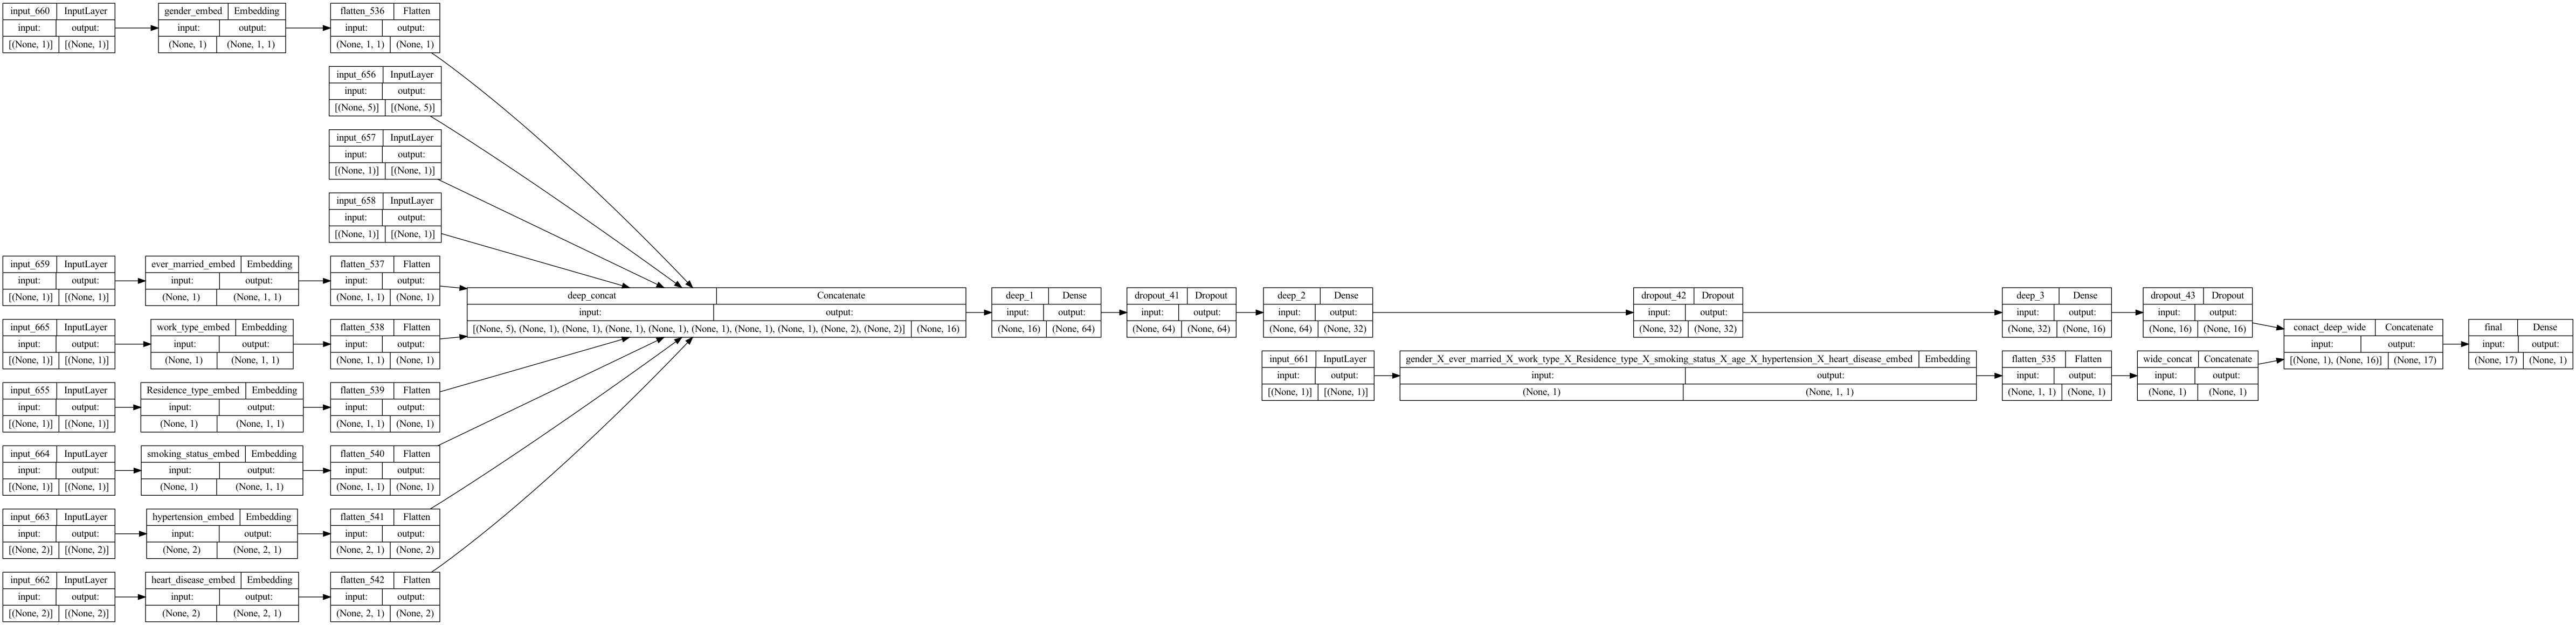

In [243]:
dict_inputs = feature_space_2.get_inputs() # need to use unprocessed features here, to gain access to each output
encoded_features = feature_space_2.get_encoded_features() # these features have been encoded

crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space_2.crossers.keys():
    
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs.append(x)

wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

all_deep_branch_outputs = []

for col in numerical_headers:
    x = encoded_features[col]
    #x = tf.cast(x,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)

deep_branch = Concatenate(name='deep_concat')(all_deep_branch_outputs)
deep_branch = Dense(64, activation='relu', name='deep_1')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)
deep_branch = Dense(32, activation='relu', name='deep_2')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)
deep_branch = Dense(16, activation='relu', name='deep_3')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)

final_branch = Concatenate(name='conact_deep_wide')([wide_branch, deep_branch])
final_branch = Dense(1, activation='sigmoid', name='final')(final_branch)

training_model_network3 = Model(inputs=encoded_features, outputs=final_branch)
training_model_network3.compile(optimizer='adam', loss='binary_crossentropy', 
                        metrics=[
                            'accuracy', 
                            Precision(name='precision'),
                            Recall(name='recall'),
                            AUC(name='auc')])

training_model_network3.summary()

plot_model(
    training_model_network3, show_shapes=True, show_layer_names=True, to_file='model.png',
    rankdir='LR', expand_nested=False, dpi=96
)

In [244]:
network3_history = training_model_network3.fit(preprocessed_ds_train_2, epochs=10, validation_data=preprocessed_ds_test_2, verbose=2)

Epoch 1/10


2023-11-09 19:44:39.381744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:45:16.099425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 - 48s - loss: 0.5662 - accuracy: 0.7020 - precision: 0.6003 - recall: 0.4446 - auc: 0.7369 - val_loss: 0.3556 - val_accuracy: 0.8112 - val_precision: 0.1478 - val_recall: 0.6000 - val_auc: 0.8383 - 48s/epoch - 509ms/step
Epoch 2/10
94/94 - 5s - loss: 0.5044 - accuracy: 0.7408 - precision: 0.6442 - recall: 0.5793 - auc: 0.8092 - val_loss: 0.3724 - val_accuracy: 0.8033 - val_precision: 0.1455 - val_recall: 0.6200 - val_auc: 0.8355 - 5s/epoch - 56ms/step
Epoch 3/10
94/94 - 4s - loss: 0.4928 - accuracy: 0.7530 - precision: 0.6567 - recall: 0.6165 - auc: 0.8192 - val_loss: 0.3858 - val_accuracy: 0.7965 - val_precision: 0.1409 - val_recall: 0.6200 - val_auc: 0.8352 - 4s/epoch - 45ms/step
Epoch 4/10
94/94 - 3s - loss: 0.4896 - accuracy: 0.7510 - precision: 0.6492 - recall: 0.6275 - auc: 0.8203 - val_loss: 0.3578 - val_accuracy: 0.8141 - val_precision: 0.1465 - val_recall: 0.5800 - val_auc: 0.8420 - 3s/epoch - 37ms/step
Epoch 5/10
94/94 - 3s - loss: 0.4876 - accuracy: 0.7451 - precision:

In [341]:
F1_beta_training = calculate_F1_beta(network3_history.history['precision'], network3_history.history['recall'], 10)
F1_beta_validation = calculate_F1_beta(network3_history.history['val_precision'], network3_history.history['val_recall'], 10)

print('F1 beta score training: ', F1_beta_training[-1])
print('F1 beta score validation: ', F1_beta_validation[-1])

F1 beta score training:  0.5998135716076898
F1 beta score validation:  0.5830286927638616


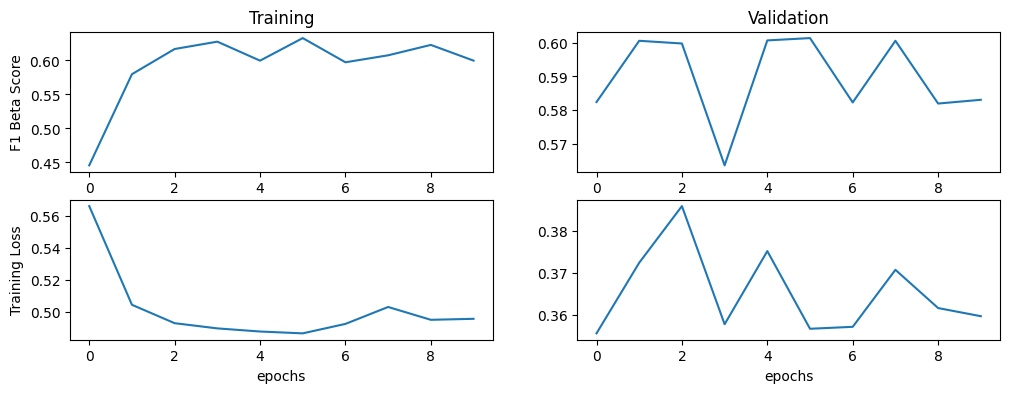

In [342]:
# Plot the training and validation accuracy and loss at each epoch

plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(F1_beta_training)

plt.ylabel('F1 Beta Score')
plt.title('Training')
plt.subplot(2, 2, 2)
plt.plot(F1_beta_validation)
plt.title('Validation')

plt.subplot(2, 2, 3)
plt.plot(network3_history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2, 2, 4)
plt.plot(network3_history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

### Alterting the number of deep layers

We decided to alter the number of layers for network 1 and 2. Currently they each have 3 dense layers and 1 output layer. We decided to add and substract 1 dense layer from the networks to see how it would affect the performance of the network.

#### Network 1: Adding a dense layer

Model: "model_84"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_685 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_683 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_689 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_678 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                           

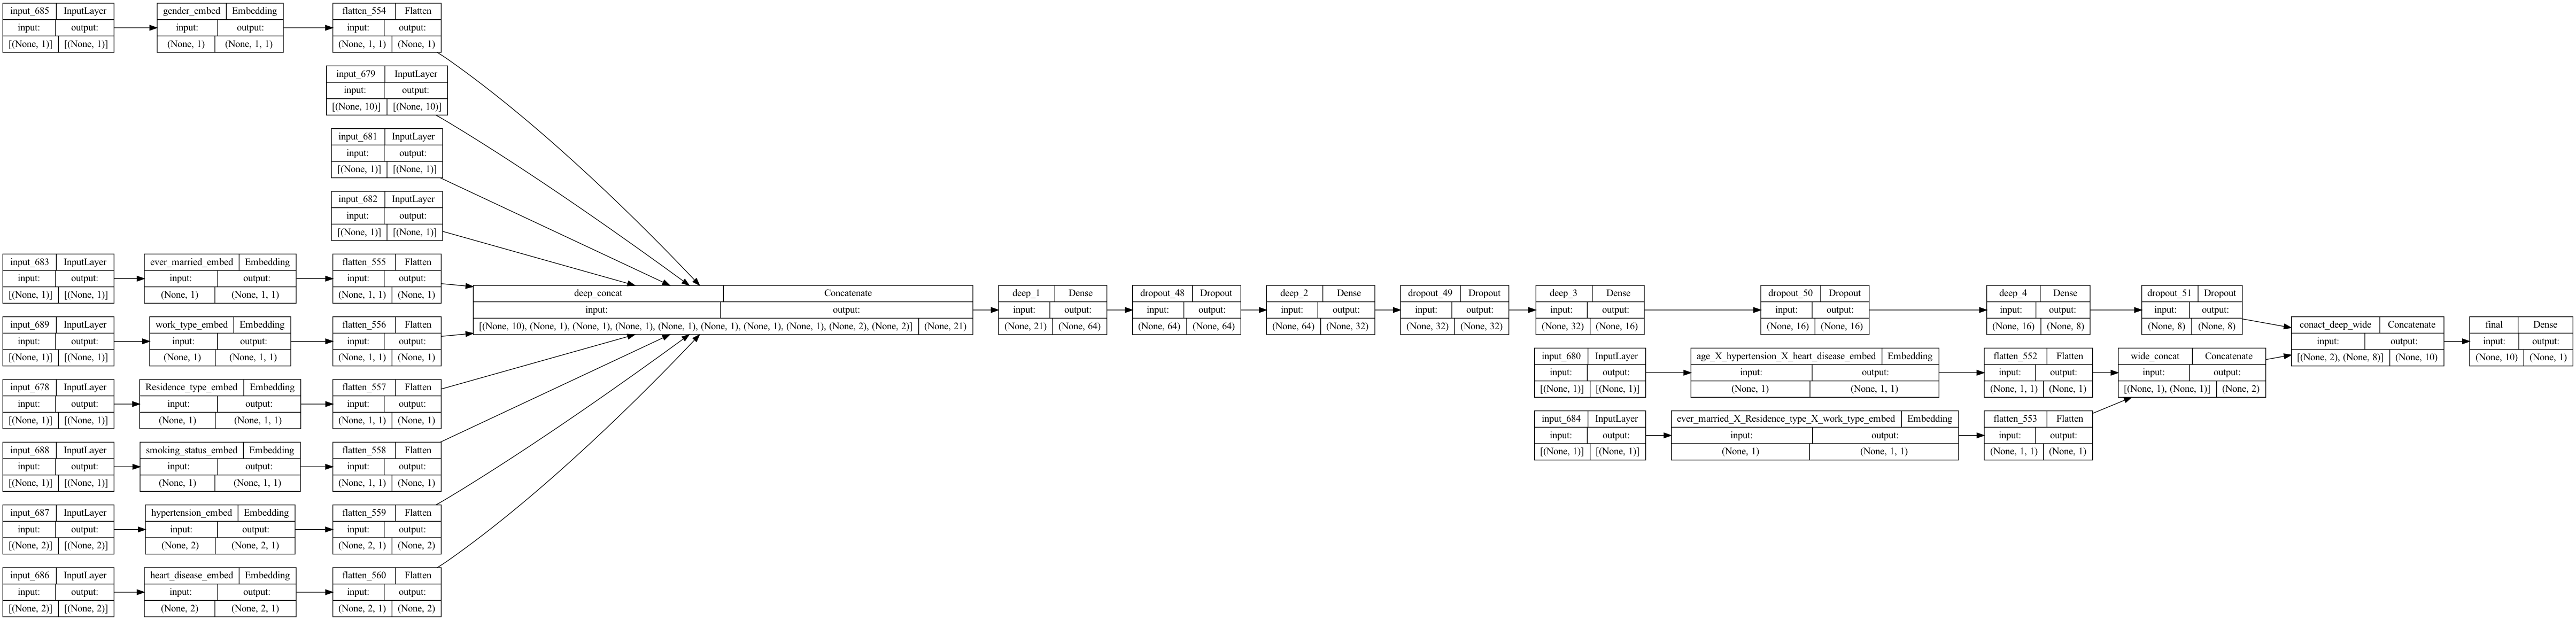

In [250]:
# add one more dense layer to wide and deep network #1
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
encoded_features = feature_space.get_encoded_features() # these features have been encoded

crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():
    
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs.append(x)

wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

all_deep_branch_outputs = []

for col in numerical_headers:
    x = encoded_features[col]
    #x = tf.cast(x,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)

deep_branch = Concatenate(name='deep_concat')(all_deep_branch_outputs)
deep_branch = Dense(64, activation='relu', name='deep_1')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)
deep_branch = Dense(32, activation='relu', name='deep_2')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)
deep_branch = Dense(16, activation='relu', name='deep_3')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)
deep_branch = Dense(8, activation='relu', name='deep_4')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)

final_branch = Concatenate(name='conact_deep_wide')([wide_branch, deep_branch])
final_branch = Dense(1, activation='sigmoid', name='final')(final_branch)


metric = tf.keras.metrics.FBetaScore(beta=2.0, threshold=0.5)

training_model_network1_add = Model(inputs=encoded_features, outputs=final_branch)
training_model_network1_add.compile(optimizer='adam', loss='binary_crossentropy', 
                    metrics=[
                        'accuracy', 
                        Precision(name='precision'),
                        Recall(name='recall'),
                        AUC(name='auc')])

training_model_network1_add.summary()


plot_model(
    training_model_network1_add, show_shapes=True, show_layer_names=True, to_file='model.png',
    rankdir='LR', expand_nested=False, dpi=96
)

In [251]:
network1_add_history = training_model_network1_add.fit(preprocessed_ds_train, epochs=10, validation_data=preprocessed_ds_test, verbose=2)

Epoch 1/10


2023-11-09 19:48:50.426173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 19:49:32.123916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 - 55s - loss: 0.6245 - accuracy: 0.6702 - precision: 0.5350 - recall: 0.4422 - auc: 0.6913 - val_loss: 0.3586 - val_accuracy: 0.8425 - val_precision: 0.1636 - val_recall: 0.5400 - val_auc: 0.8337 - 55s/epoch - 581ms/step
Epoch 2/10
94/94 - 7s - loss: 0.5702 - accuracy: 0.7095 - precision: 0.5942 - recall: 0.5363 - auc: 0.7669 - val_loss: 0.3388 - val_accuracy: 0.8337 - val_precision: 0.1703 - val_recall: 0.6200 - val_auc: 0.8403 - 7s/epoch - 71ms/step
Epoch 3/10
94/94 - 5s - loss: 0.6003 - accuracy: 0.7107 - precision: 0.5956 - recall: 0.5401 - auc: 0.7635 - val_loss: 0.3960 - val_accuracy: 0.8053 - val_precision: 0.1629 - val_recall: 0.7200 - val_auc: 0.8413 - 5s/epoch - 54ms/step
Epoch 4/10
94/94 - 4s - loss: 0.7231 - accuracy: 0.6851 - precision: 0.5479 - recall: 0.5731 - auc: 0.7387 - val_loss: 0.3211 - val_accuracy: 0.8405 - val_precision: 0.1734 - val_recall: 0.6000 - val_auc: 0.8387 - 4s/epoch - 39ms/step
Epoch 5/10
94/94 - 4s - loss: 1.3689 - accuracy: 0.6572 - precision:

In [339]:
F1_beta_training = calculate_F1_beta(network1_add_history.history['precision'], network1_add_history.history['recall'], 2)
F1_beta_validation = calculate_F1_beta(network1_add_history.history['val_precision'], network1_add_history.history['val_recall'], 2)

print('F1 beta score training: ', F1_beta_training[-1])
print('F1 beta score validation: ', F1_beta_validation[-1])

F1 beta score training:  0.445745801757517
F1 beta score validation:  0.30334727795167954


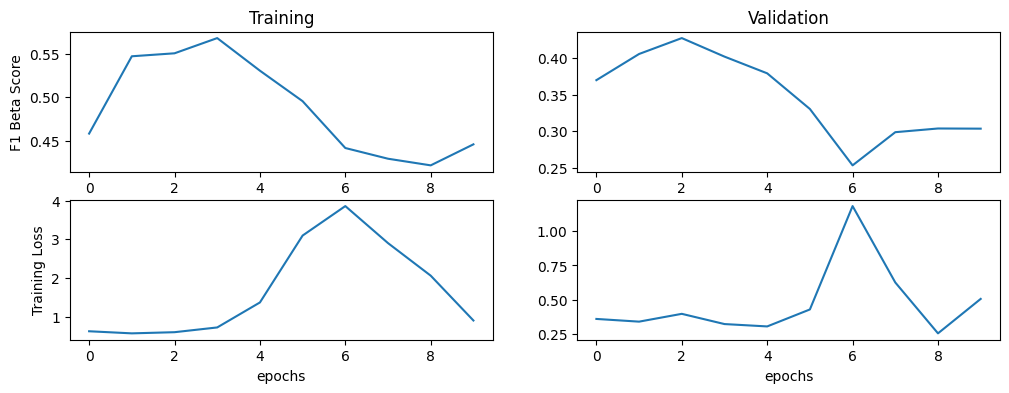

In [340]:
# Plot the training and validation accuracy and loss at each epoch

plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(F1_beta_training)

plt.ylabel('F1 Beta Score')
plt.title('Training')
plt.subplot(2, 2, 2)
plt.plot(F1_beta_validation)
plt.title('Validation')

plt.subplot(2, 2, 3)
plt.plot(network1_add_history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2, 2, 4)
plt.plot(network1_add_history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

In [299]:
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency

network1_predictions = training_model_network1.predict(preprocessed_ds_test) 
network1_add_predictions = training_model_network1_add.predict(preprocessed_ds_test)

# Convert predicted probabilities to binary predictions
network1_binary = (network1_predictions > 0.5).astype(int)
network1_add_binary = (network1_add_predictions > 0.5).astype(int)

y_test = np.concatenate([y for x, y in ds_test.as_numpy_iterator()])
# Get confusion matrix values
conf_matrix1 = confusion_matrix(y_test, network1_binary)  # Replace y_test with your true labels
conf_matrix2 = confusion_matrix(y_test, network1_add_binary)

# Construct the contingency table
table = [
    [conf_matrix1[1, 1], conf_matrix1[1, 0]],
    [conf_matrix2[1, 1], conf_matrix2[1, 0]]
]
print(table)

# Perform McNemar's test
stat, p_value, _, _ = chi2_contingency(table)

print('Chi-squared statistic:', stat)
print('P-value:', p_value)

# Interpret the results
alpha = 0.05
if p_value <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')


16/16 [==============================] - 0s 18ms/step
[[25, 25], [26, 24]]
Chi-squared statistic: 0.0
P-value: 1.0
Independent (fail to reject H0)


In [315]:
# Compare the two models with a paired t-test
from scipy.stats import ttest_rel

network1_f1 = calculate_F1_beta(network1_history.history['val_precision'], network1_history.history['val_recall'], 10)
network1_add_f1 = calculate_F1_beta(network1_add_history.history['val_precision'], network1_add_history.history['val_recall'], 10)

t_stat, p_value = ttest_rel(network1_f1, network1_add_f1)

print('T-statistic:', t_stat)
print('P-value:', p_value)

# Interpret the results
alpha = 0.05
if p_value <= alpha:
    print('The models are statistically different. (reject H0)')
else:
    print('There is no significant difference between the models. (fail to reject H0)')

T-statistic: 2.045215017953774
P-value: 0.0711624434865235
There is no significant difference between the models. (fail to reject H0)


#### Network 1: Substracting a dense layer

Model: "model_93"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_789 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_787 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_793 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_782 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                           

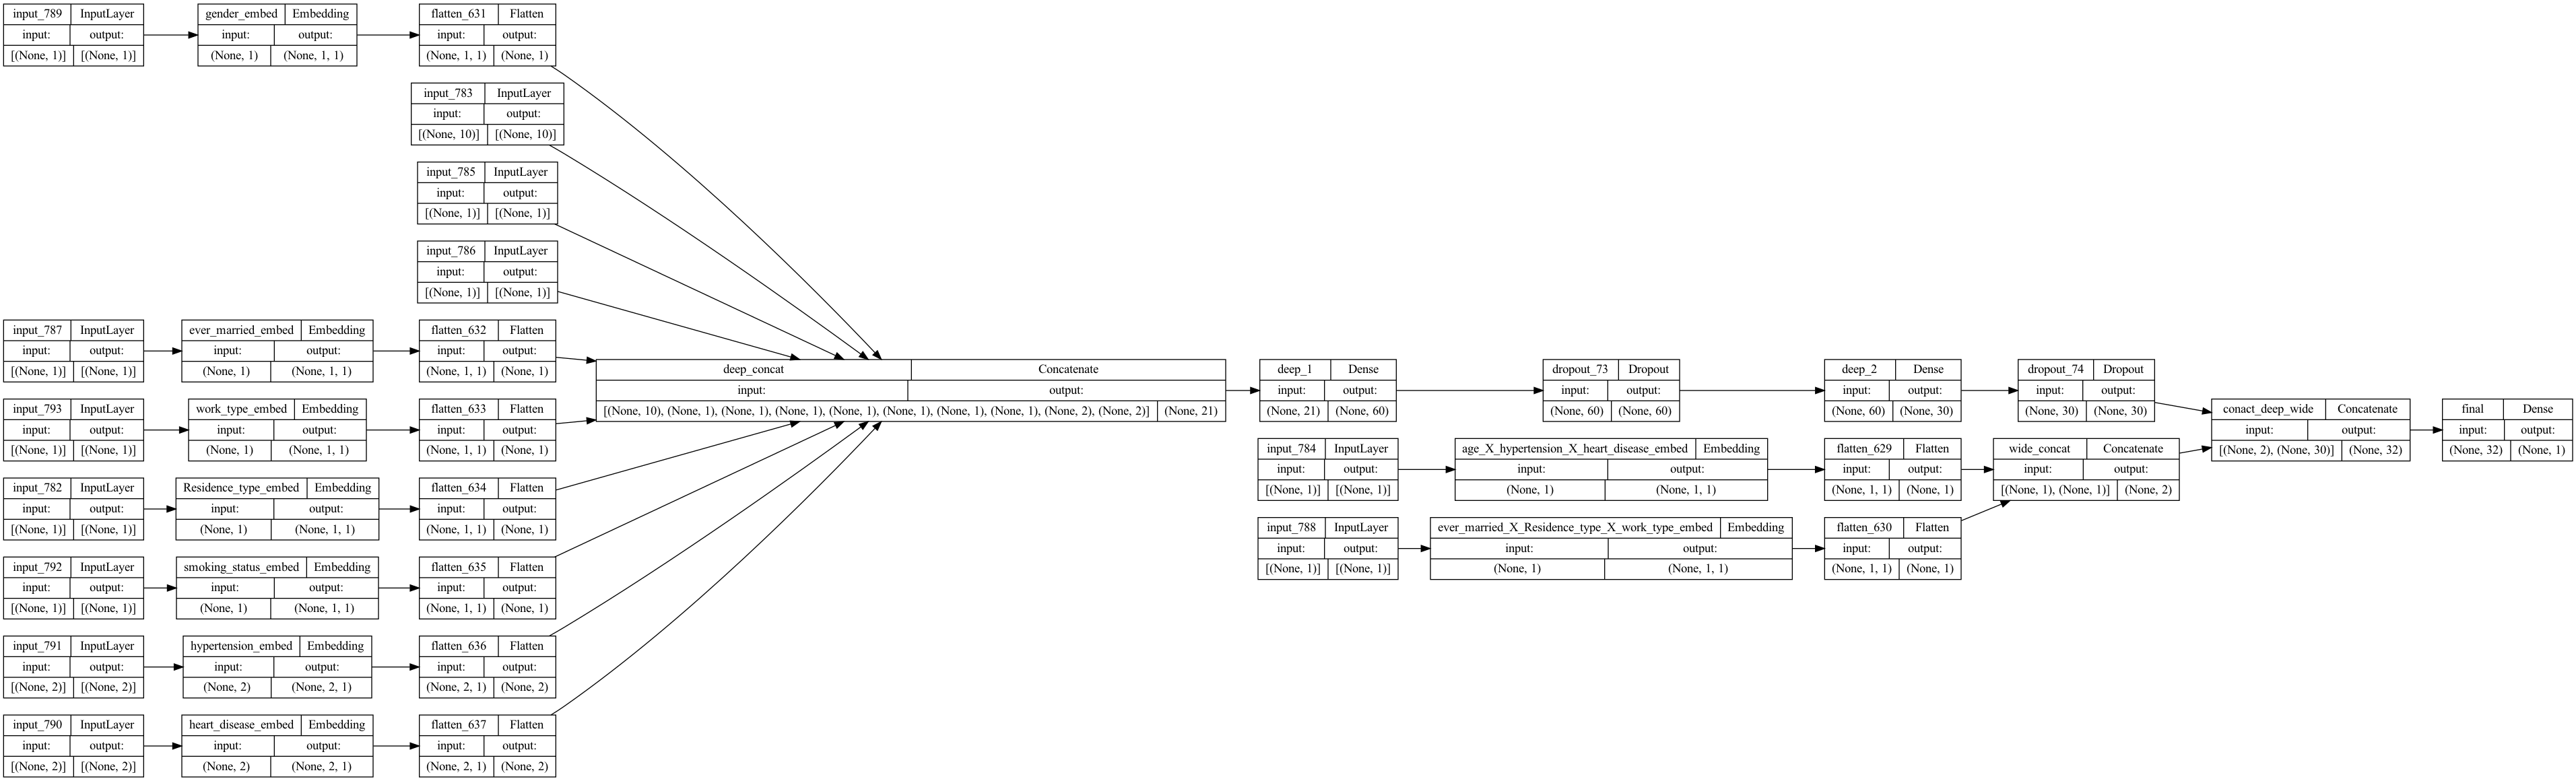

In [310]:
# add one more dense layer to wide and deep network #1
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
encoded_features = feature_space.get_encoded_features() # these features have been encoded

crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():
    
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs.append(x)

wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

all_deep_branch_outputs = []

for col in numerical_headers:
    x = encoded_features[col]
    #x = tf.cast(x,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)

deep_branch = Concatenate(name='deep_concat')(all_deep_branch_outputs)
deep_branch = Dense(60, activation='relu', name='deep_1')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)
deep_branch = Dense(30, activation='relu', name='deep_2')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)

final_branch = Concatenate(name='conact_deep_wide')([wide_branch, deep_branch])
final_branch = Dense(1, activation='sigmoid', name='final')(final_branch)


metric = tf.keras.metrics.FBetaScore(beta=2.0, threshold=0.5)

training_model_network1_sub = Model(inputs=encoded_features, outputs=final_branch)
training_model_network1_sub.compile(optimizer='adam', loss='binary_crossentropy', 
                    metrics=[
                        'accuracy', 
                        Precision(name='precision'),
                        Recall(name='recall'),
                        AUC(name='auc')])

training_model_network1_sub.summary()


plot_model(
    training_model_network1_sub, show_shapes=True, show_layer_names=True, to_file='model.png',
    rankdir='LR', expand_nested=False, dpi=96
)

In [311]:
network1_sub_history = training_model_network1_sub.fit(preprocessed_ds_train, epochs=10, validation_data=preprocessed_ds_test, verbose=2)

Epoch 1/10


2023-11-10 15:00:56.211089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-10 15:01:39.063387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 - 56s - loss: 0.5919 - accuracy: 0.6609 - precision: 0.5244 - recall: 0.3333 - auc: 0.7000 - val_loss: 0.3603 - val_accuracy: 0.8620 - val_precision: 0.1579 - val_recall: 0.4200 - val_auc: 0.8285 - 56s/epoch - 598ms/step
Epoch 2/10
94/94 - 5s - loss: 0.4850 - accuracy: 0.7533 - precision: 0.6726 - recall: 0.5750 - auc: 0.8260 - val_loss: 0.3562 - val_accuracy: 0.8278 - val_precision: 0.1684 - val_recall: 0.6400 - val_auc: 0.8416 - 5s/epoch - 51ms/step
Epoch 3/10
94/94 - 5s - loss: 0.4728 - accuracy: 0.7632 - precision: 0.6737 - recall: 0.6270 - auc: 0.8332 - val_loss: 0.3663 - val_accuracy: 0.8278 - val_precision: 0.1649 - val_recall: 0.6200 - val_auc: 0.8349 - 5s/epoch - 54ms/step
Epoch 4/10
94/94 - 4s - loss: 0.4736 - accuracy: 0.7637 - precision: 0.6698 - recall: 0.6404 - auc: 0.8323 - val_loss: 0.3726 - val_accuracy: 0.8209 - val_precision: 0.1624 - val_recall: 0.6400 - val_auc: 0.8355 - 4s/epoch - 46ms/step
Epoch 5/10
94/94 - 4s - loss: 0.4788 - accuracy: 0.7523 - precision:

In [335]:
F1_beta_training = calculate_F1_beta(network1_sub_history.history['precision'], network1_sub_history.history['recall'], 10)
F1_beta_validation = calculate_F1_beta(network1_sub_history.history['val_precision'], network1_sub_history.history['val_recall'], 10)

print('F1 beta score training: ', F1_beta_training[-1])
print('F1 beta score validation: ', F1_beta_validation[-1])

F1 beta score training:  0.6021035330551621
F1 beta score validation:  0.5838150504019011


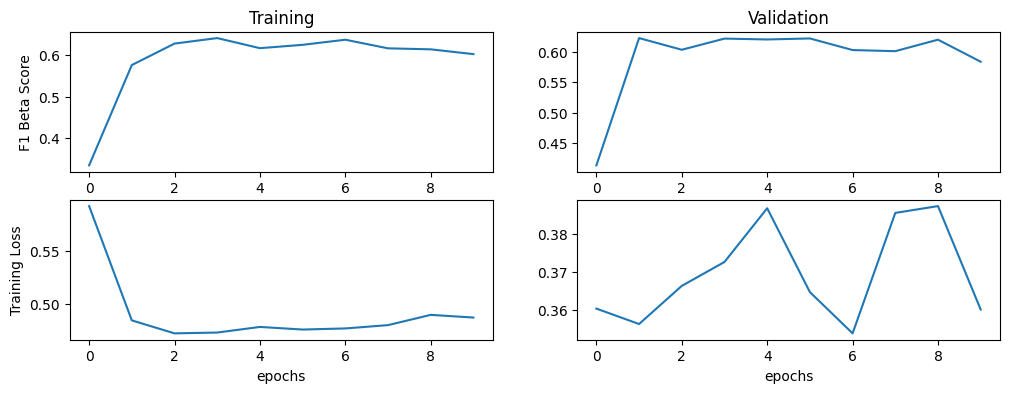

In [336]:
# Plot the training and validation accuracy and loss at each epoch

plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(F1_beta_training)

plt.ylabel('F1 Beta Score')
plt.title('Training')
plt.subplot(2, 2, 2)
plt.plot(F1_beta_validation)
plt.title('Validation')

plt.subplot(2, 2, 3)
plt.plot(network1_sub_history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2, 2, 4)
plt.plot(network1_sub_history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

In [318]:
# statistical test

network1_sub_f1 = calculate_F1_beta(network1_sub_history.history['val_precision'], network1_sub_history.history['val_recall'], 10)

t_stat, p_value = ttest_rel(network1_f1, network1_sub_f1)

print('T-statistic:', t_stat)
print('P-value:', p_value)

# Interpret the results
alpha = 0.05
if p_value <= alpha:
    print('The models are statistically different. (reject H0)')
else:
    print('There is no significant difference between the models. (fail to reject H0)')

T-statistic: -0.7267401415478646
P-value: 0.48585667020108225
There is no significant difference between the models. (fail to reject H0)


#### Network 2: Adding a dense layer

Model: "model_94"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_801 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_799 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_805 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_794 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                           

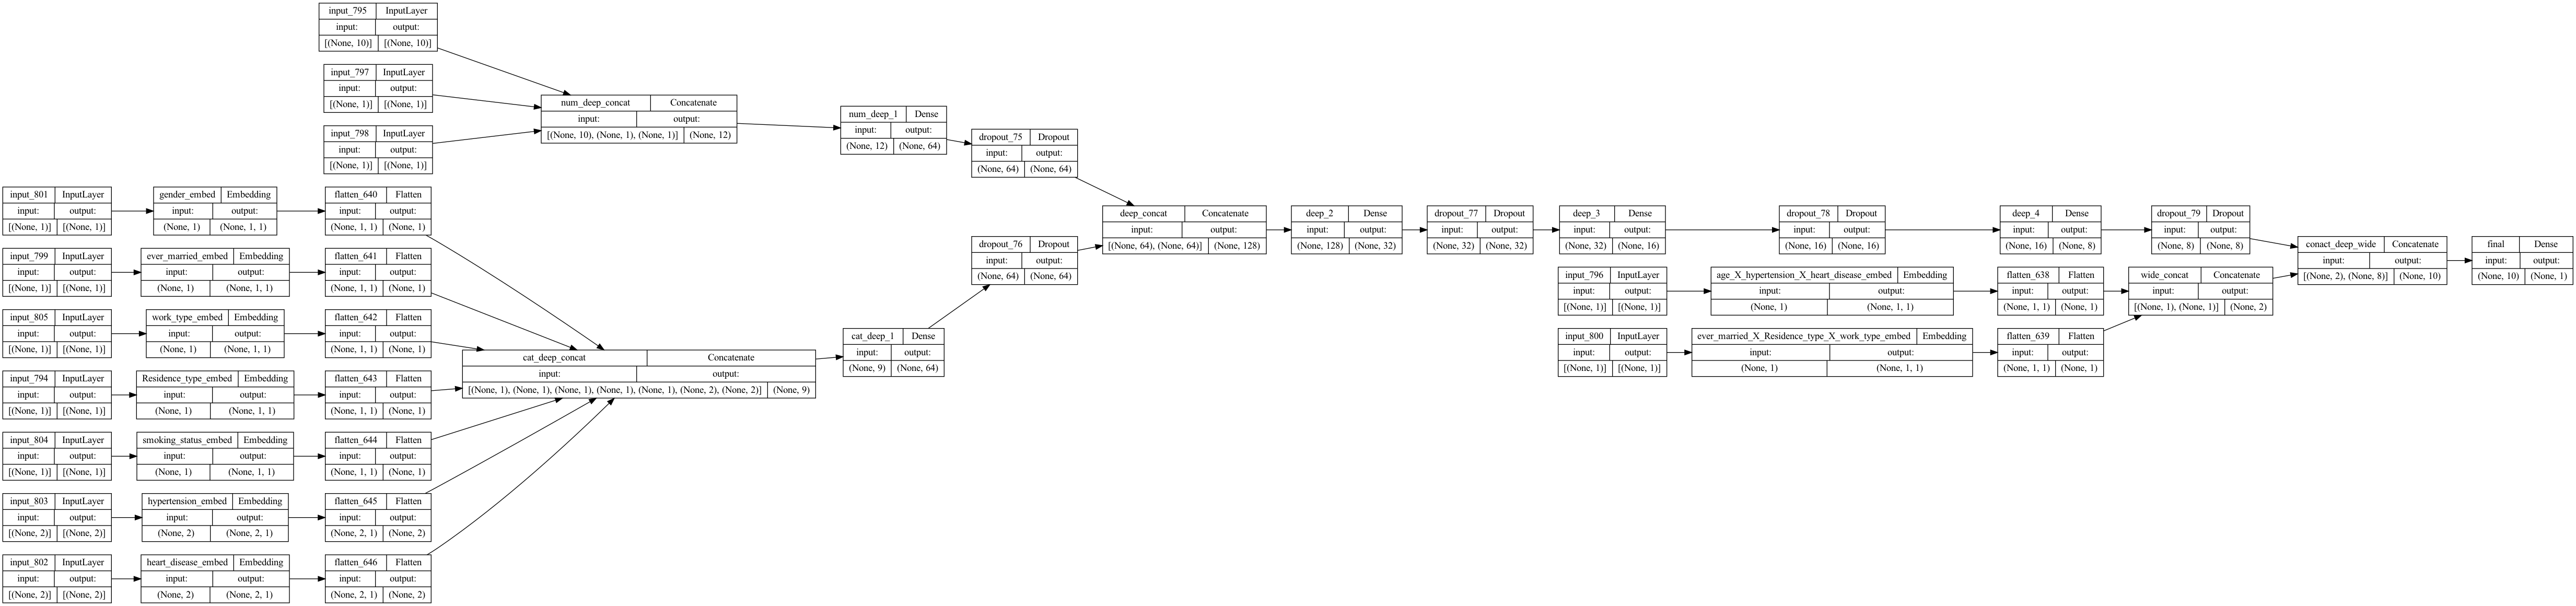

In [320]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
encoded_features = feature_space.get_encoded_features() # these features have been encoded

crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():
    
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs.append(x)

wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

numeric_deep_branch_outputs = []
categorical_deep_branch_outputs = []

for col in numerical_headers:
    x = encoded_features[col]
    #x = tf.cast(x,float) # cast an integer as a float here
    numeric_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    categorical_deep_branch_outputs.append(x)

num_deep_branch = Concatenate(name='num_deep_concat')(numeric_deep_branch_outputs)
num_deep_branch = Dense(64, activation='relu', name='num_deep_1')(num_deep_branch)
num_deep_branch = Dropout(0.2)(num_deep_branch)

cat_deep_branch = Concatenate(name='cat_deep_concat')(categorical_deep_branch_outputs)
cat_deep_branch = Dense(64, activation='relu', name='cat_deep_1')(cat_deep_branch)
cat_deep_branch = Dropout(0.2)(cat_deep_branch)

deep_branch = Concatenate(name='deep_concat')([num_deep_branch, cat_deep_branch])
deep_branch = Dense(32, activation='relu', name='deep_2')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)
deep_branch = Dense(16, activation='relu', name='deep_3')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)
deep_branch = Dense(8, activation='relu', name='deep_4')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)

final_branch = Concatenate(name='conact_deep_wide')([wide_branch, deep_branch])
final_branch = Dense(1, activation='sigmoid', name='final')(final_branch)

training_model_network2_add = Model(inputs=encoded_features, outputs=final_branch)
training_model_network2_add.compile(optimizer='adam', loss='binary_crossentropy', 
                    metrics=[
                        'accuracy', 
                        Precision(name='precision'),
                        Recall(name='recall'),
                        AUC(name='auc')])

training_model_network2_add.summary()

plot_model(
    training_model_network2_add, show_shapes=True, show_layer_names=True, to_file='model.png',
    rankdir='LR', expand_nested=False, dpi=96
)

In [321]:
network2_add_history = training_model_network2_add.fit(preprocessed_ds_train, epochs=10, validation_data=preprocessed_ds_test, verbose=2)

Epoch 1/10


2023-11-10 15:05:30.592018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-10 15:06:21.044245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 - 66s - loss: 0.6292 - accuracy: 0.6625 - precision: 0.5326 - recall: 0.2923 - auc: 0.6259 - val_loss: 0.4397 - val_accuracy: 0.8767 - val_precision: 0.1667 - val_recall: 0.3800 - val_auc: 0.7693 - 66s/epoch - 698ms/step
Epoch 2/10
94/94 - 8s - loss: 0.5546 - accuracy: 0.7142 - precision: 0.6220 - recall: 0.4675 - auc: 0.7602 - val_loss: 0.3939 - val_accuracy: 0.8395 - val_precision: 0.1686 - val_recall: 0.5800 - val_auc: 0.8220 - 8s/epoch - 85ms/step
Epoch 3/10
94/94 - 6s - loss: 0.5242 - accuracy: 0.7332 - precision: 0.6376 - recall: 0.5511 - auc: 0.7977 - val_loss: 0.3636 - val_accuracy: 0.8307 - val_precision: 0.1639 - val_recall: 0.6000 - val_auc: 0.8382 - 6s/epoch - 63ms/step
Epoch 4/10
94/94 - 5s - loss: 0.5093 - accuracy: 0.7419 - precision: 0.6550 - recall: 0.5549 - auc: 0.8079 - val_loss: 0.3569 - val_accuracy: 0.8219 - val_precision: 0.1562 - val_recall: 0.6000 - val_auc: 0.8373 - 5s/epoch - 52ms/step
Epoch 5/10
94/94 - 4s - loss: 0.5130 - accuracy: 0.7374 - precision:

In [333]:
F1_beta_training = calculate_F1_beta(network2_add_history.history['precision'], network2_add_history.history['recall'], 10)
F1_beta_validation = calculate_F1_beta(network2_add_history.history['val_precision'], network2_add_history.history['val_recall'], 10)

print('F1 beta score training: ', F1_beta_training[-1])
print('F1 beta score validation: ', F1_beta_validation[-1])

F1 beta score training:  0.553239962914793
F1 beta score validation:  0.6386281151096548


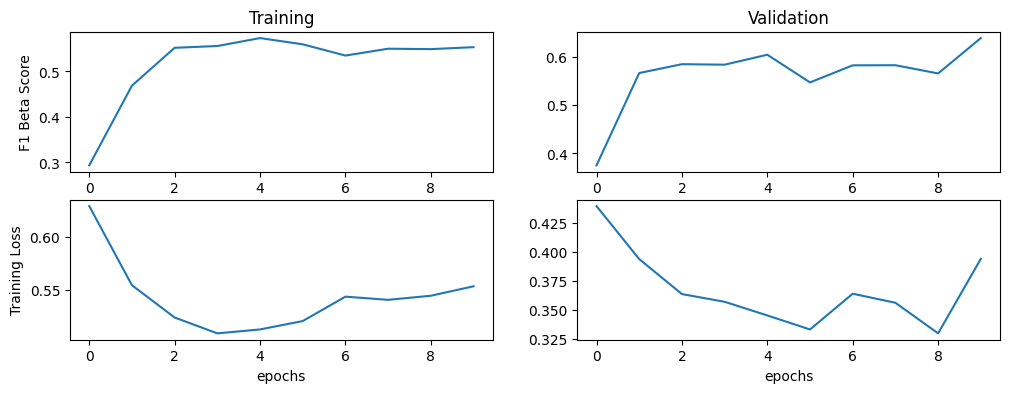

In [334]:
# Plot the training and validation accuracy and loss at each epoch

plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(F1_beta_training)

plt.ylabel('F1 Beta Score')
plt.title('Training')
plt.subplot(2, 2, 2)
plt.plot(F1_beta_validation)
plt.title('Validation')

plt.subplot(2, 2, 3)
plt.plot(network2_add_history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2, 2, 4)
plt.plot(network2_add_history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

In [326]:
# statistical test

network2_f1 = calculate_F1_beta(network2_history.history['val_precision'], network2_history.history['val_recall'], 10)
network2_add_f1 = calculate_F1_beta(network2_add_history.history['val_precision'], network2_add_history.history['val_recall'], 10)

print('network2 f1 beta score:', network2_f1[-1])
print('network2 add f1 beta score:', network2_add_f1[-1])

t_stat, p_value = ttest_rel(network2_f1, network2_add_f1)

print('T-statistic:', t_stat)
print('P-value:', p_value)

# Interpret the results
alpha = 0.05
if p_value <= alpha:
    print('The models are statistically different. (reject H0)')
else:
    print('There is no significant difference between the models. (fail to reject H0)')

network2 f1 beta score: 0.6597502477196086
network2 add f1 beta score: 0.6386281151096548
T-statistic: 3.348435097639107
P-value: 0.008544775542442165
The models are statistically different. (reject H0)


#### Network 2: Substracting a dense layer

Model: "model_95"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_813 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_811 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_817 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_806 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                           

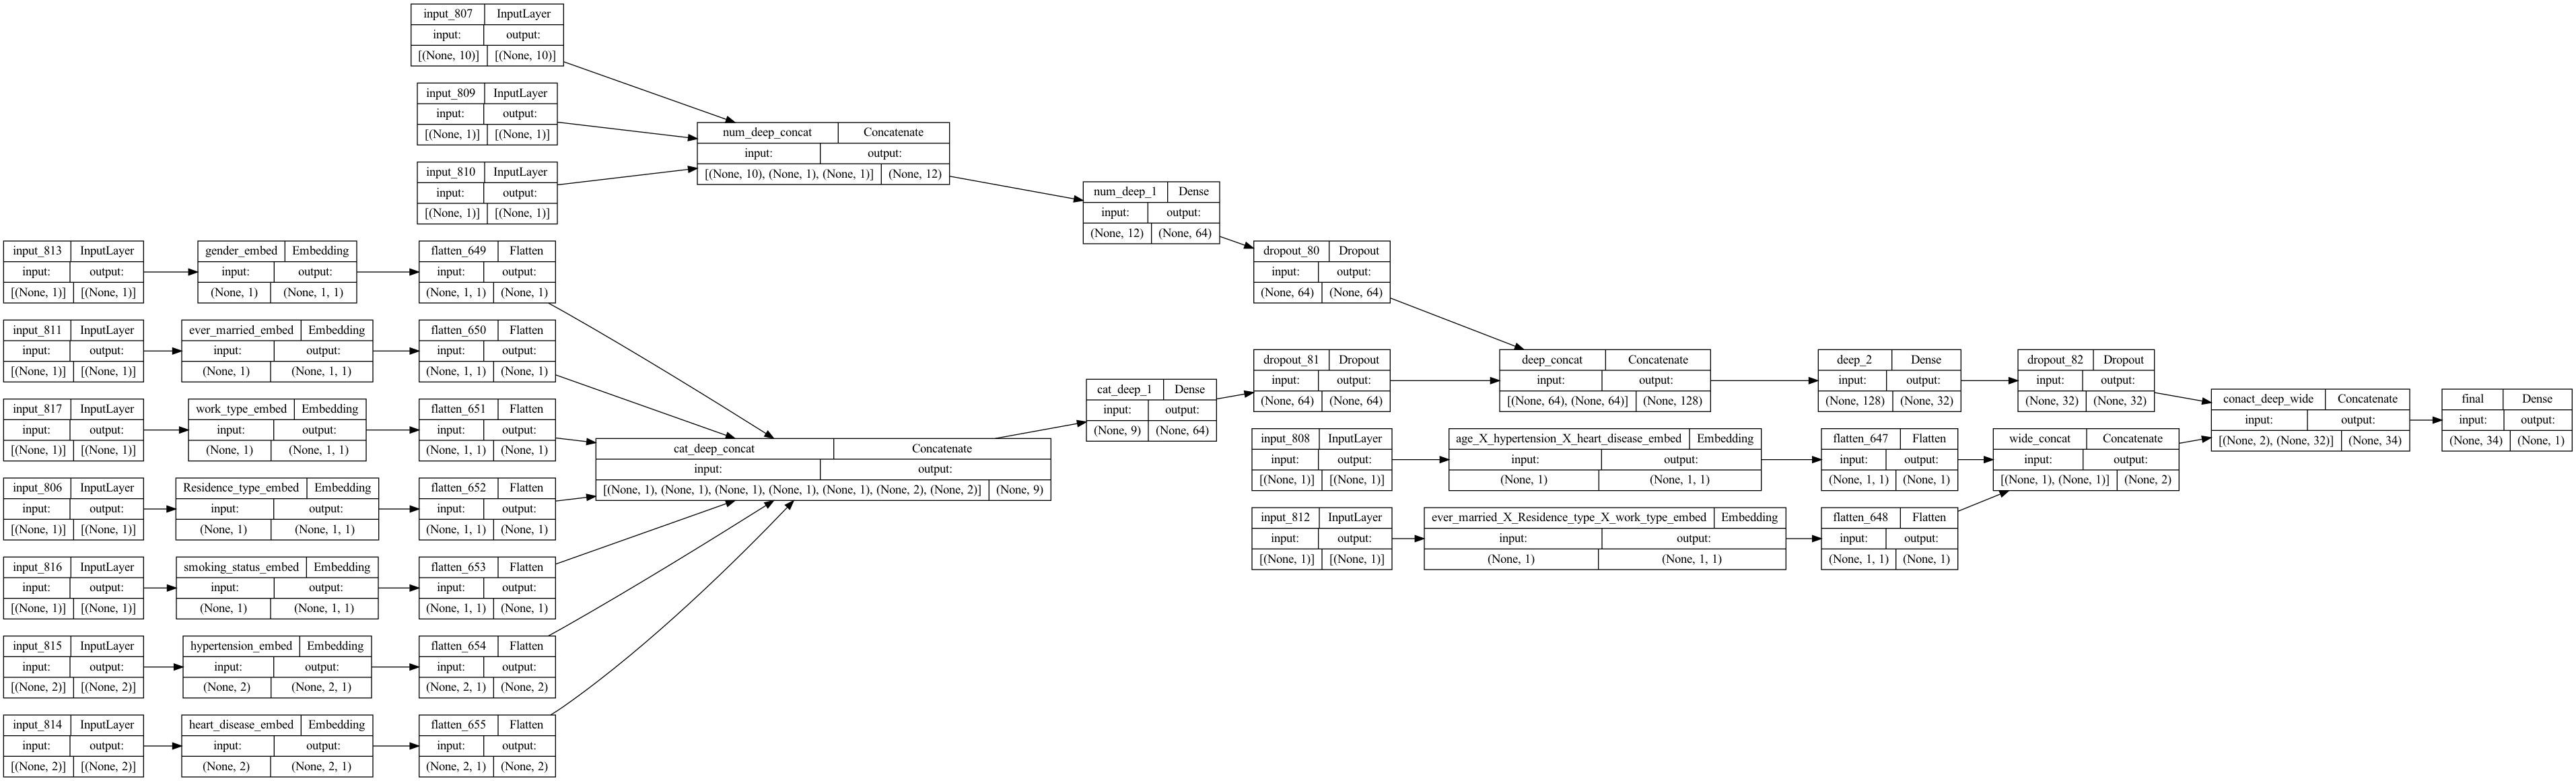

In [327]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
encoded_features = feature_space.get_encoded_features() # these features have been encoded

crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():
    
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs.append(x)

wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

numeric_deep_branch_outputs = []
categorical_deep_branch_outputs = []

for col in numerical_headers:
    x = encoded_features[col]
    #x = tf.cast(x,float) # cast an integer as a float here
    numeric_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_encoding(encoded_features, col)
    
    # save these outputs in list to concatenate later
    categorical_deep_branch_outputs.append(x)

num_deep_branch = Concatenate(name='num_deep_concat')(numeric_deep_branch_outputs)
num_deep_branch = Dense(64, activation='relu', name='num_deep_1')(num_deep_branch)
num_deep_branch = Dropout(0.2)(num_deep_branch)

cat_deep_branch = Concatenate(name='cat_deep_concat')(categorical_deep_branch_outputs)
cat_deep_branch = Dense(64, activation='relu', name='cat_deep_1')(cat_deep_branch)
cat_deep_branch = Dropout(0.2)(cat_deep_branch)

deep_branch = Concatenate(name='deep_concat')([num_deep_branch, cat_deep_branch])
deep_branch = Dense(32, activation='relu', name='deep_2')(deep_branch)
deep_branch = Dropout(0.2)(deep_branch)

final_branch = Concatenate(name='conact_deep_wide')([wide_branch, deep_branch])
final_branch = Dense(1, activation='sigmoid', name='final')(final_branch)

training_model_network2_sub = Model(inputs=encoded_features, outputs=final_branch)
training_model_network2_sub.compile(optimizer='adam', loss='binary_crossentropy', 
                    metrics=[
                        'accuracy', 
                        Precision(name='precision'),
                        Recall(name='recall'),
                        AUC(name='auc')])

training_model_network2_sub.summary()

plot_model(
    training_model_network2_sub, show_shapes=True, show_layer_names=True, to_file='model.png',
    rankdir='LR', expand_nested=False, dpi=96
)

In [269]:
network2_sub_history = training_model_network2_sub.fit(preprocessed_ds_train, epochs=10, validation_data=preprocessed_ds_test, verbose=2)

Epoch 1/10


2023-11-09 20:02:45.790962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 20:03:31.232228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 - 59s - loss: 0.5516 - accuracy: 0.7134 - precision: 0.6243 - recall: 0.4546 - auc: 0.7697 - val_loss: 0.3707 - val_accuracy: 0.8307 - val_precision: 0.1813 - val_recall: 0.7000 - val_auc: 0.8610 - 59s/epoch - 628ms/step
Epoch 2/10
94/94 - 5s - loss: 0.4828 - accuracy: 0.7573 - precision: 0.6713 - recall: 0.6008 - auc: 0.8291 - val_loss: 0.3793 - val_accuracy: 0.8141 - val_precision: 0.1729 - val_recall: 0.7400 - val_auc: 0.8565 - 5s/epoch - 53ms/step
Epoch 3/10
94/94 - 4s - loss: 0.4749 - accuracy: 0.7608 - precision: 0.6672 - recall: 0.6318 - auc: 0.8327 - val_loss: 0.3388 - val_accuracy: 0.8356 - val_precision: 0.1722 - val_recall: 0.6200 - val_auc: 0.8547 - 4s/epoch - 41ms/step
Epoch 4/10
94/94 - 4s - loss: 0.4686 - accuracy: 0.7597 - precision: 0.6657 - recall: 0.6294 - auc: 0.8371 - val_loss: 0.3051 - val_accuracy: 0.8483 - val_precision: 0.1739 - val_recall: 0.5600 - val_auc: 0.8441 - 4s/epoch - 39ms/step
Epoch 5/10
94/94 - 5s - loss: 0.4725 - accuracy: 0.7558 - precision:

In [331]:
F1_beta_training = calculate_F1_beta(network2_sub_history.history['precision'], network2_sub_history.history['recall'], 10)
F1_beta_validation = calculate_F1_beta(network2_sub_history.history['val_precision'], network2_sub_history.history['val_recall'], 10)

print('F1 beta score training: ', F1_beta_training[-1])
print('F1 beta score validation: ', F1_beta_validation[-1])

F1 beta score training:  0.6169667971691879
F1 beta score validation:  0.6403458450624798


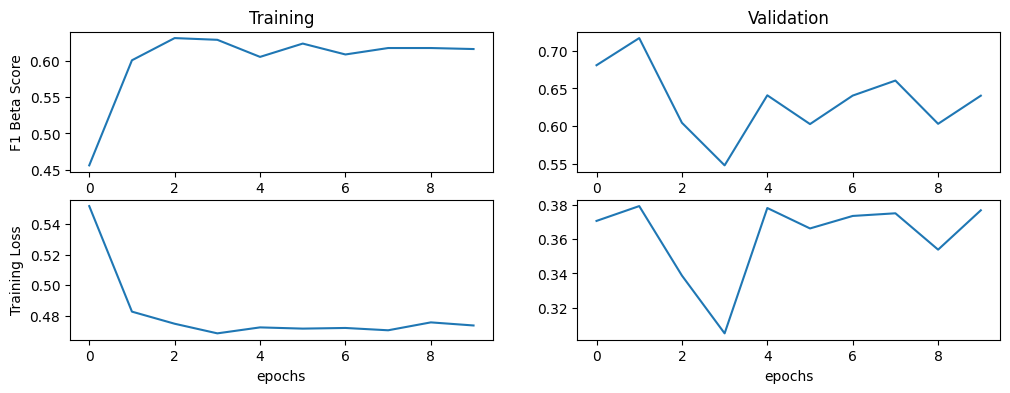

In [332]:
# Plot the training and validation accuracy and loss at each epoch

plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(F1_beta_training)

plt.ylabel('F1 Beta Score')
plt.title('Training')
plt.subplot(2, 2, 2)
plt.plot(F1_beta_validation)
plt.title('Validation')

plt.subplot(2, 2, 3)
plt.plot(network2_sub_history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2, 2, 4)
plt.plot(network2_sub_history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

In [329]:
# statistical test

network2_sub_f1 = calculate_F1_beta(network2_sub_history.history['val_precision'], network2_sub_history.history['val_recall'], 10)

t_stat, p_value = ttest_rel(network2_f1, network2_sub_f1)

print('Network2 F1 beta score:', network2_f1[-1])
print('Network2 sub F1 beta score:', network2_sub_f1[-1])
print()

print('T-statistic:', t_stat)
print('P-value:', p_value)

# Interpret the results
alpha = 0.05
if p_value <= alpha:
    print('The models are statistically different. (reject H0)')
else:
    print('There is no significant difference between the models. (fail to reject H0)')

Network2 F1 beta score: 0.6597502477196086
Network2 sub F1 beta score: 0.6403458450624798

T-statistic: -0.5667143400957806
P-value: 0.5847622816165148
There is no significant difference between the models. (fail to reject H0)


### Compare best wide and deep network to standard MLP

In [272]:
# Create the feature space with preprocessing steps applied and crossed features
feature_space_3 = FeatureSpace(
    features={

        # Categorical features encoded as string
        'gender': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'ever_married': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'work_type': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'Residence_type': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),
        'smoking_status': FeatureSpace.string_categorical(num_oov_indices=0, output_mode='int'),

        # Numerical features
        'age': FeatureSpace.float_discretized(num_bins=5),

        # Numerical features to normalize
        'avg_glucose_level': FeatureSpace.float_normalized(),
        'bmi': FeatureSpace.float_normalized(),

        # Categorical features encoded as integers
        'hypertension': FeatureSpace.integer_categorical(num_oov_indices=0),
        'heart_disease': FeatureSpace.integer_categorical(num_oov_indices=0),
    },
    output_mode='dict',
)

# Create a dataset with the feature space
train_ds_no_labels_3 = ds_train.map(lambda x, _: x)
feature_space_3.adapt(train_ds_no_labels_3)
preprocessed_ds_train_3 = ds_train.map(lambda x, y: (feature_space_3(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_train_3 = preprocessed_ds_train_3.prefetch(tf.data.AUTOTUNE)

preprocessed_ds_test_3 = ds_test.map(lambda x, y: (feature_space_3(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_test_3 = preprocessed_ds_test_3.prefetch(tf.data.AUTOTUNE)

2023-11-09 20:04:47.370147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 20:04:47.720896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 20:04:47.926144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 20:04:48.139950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 20:04:48.365028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 20:04:48.577272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 20:04:48.592605: I tensorflow/core/grappler/optimizers/cust

Model: "model_92"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_777 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_776 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_781 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 input_772 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                           

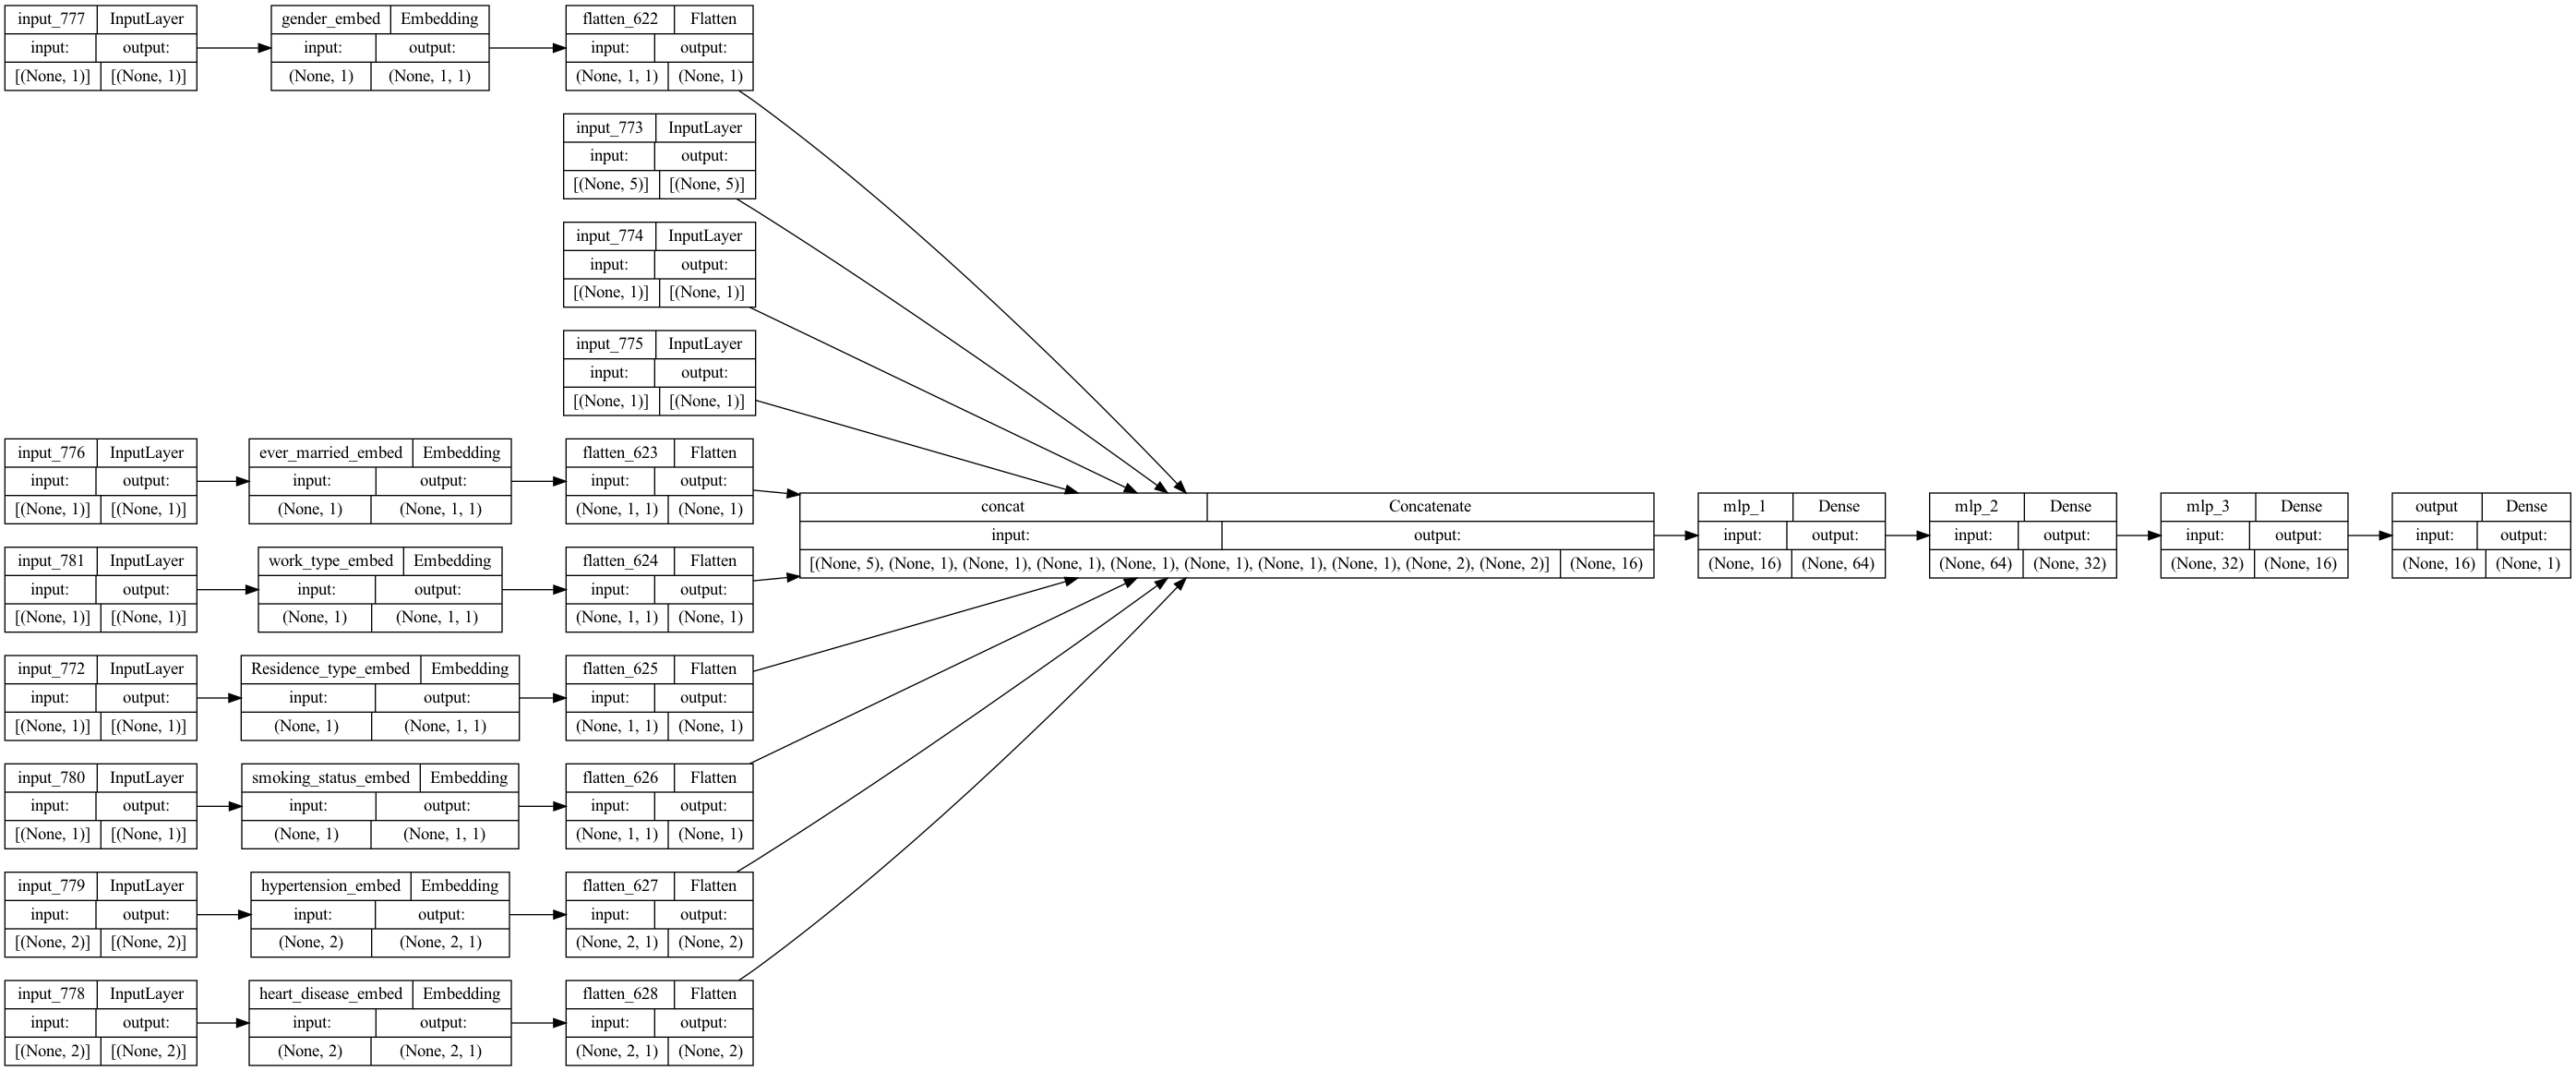

In [275]:
# create a standard multi-layer perceptron

dict_inputs = feature_space_3.get_inputs() # need to use unprocessed features here, to gain access to each output
encoded_features = feature_space_3.get_encoded_features() # these features have been encoded

all_branch_outputs = []

for col in numerical_headers:
    x = encoded_features[col]
    #x = tf.cast(x,float) # cast an integer as a float here
    all_branch_outputs.append(x)

for col in categorical_headers:
    x = setup_embedding_from_encoding(encoded_features, col)
    all_branch_outputs.append(x)

mlp = Concatenate(name='concat')(all_branch_outputs)
mlp = Dense(64, activation='relu', name='mlp_1')(mlp)
mlp = Dense(32, activation='relu', name='mlp_2')(mlp)
mlp = Dense(16, activation='relu', name='mlp_3')(mlp)

final_branch = Dense(1, activation='sigmoid', name='output')(mlp)

training_model_mlp = Model(inputs=encoded_features, outputs=final_branch)
training_model_mlp.compile(optimizer='adam', loss='binary_crossentropy', 
                    metrics=[
                        'accuracy', 
                        Precision(name='precision'),
                        Recall(name='recall'),
                        AUC(name='auc')])

training_model_mlp.summary()

plot_model(
    training_model_mlp, show_shapes=True, show_layer_names=True, to_file='model.png',
    rankdir='LR', expand_nested=False, dpi=96
)

In [274]:
mlp_history = training_model_mlp.fit(preprocessed_ds_train_3, epochs=10, validation_data=preprocessed_ds_test_3, verbose=2)

Epoch 1/10


2023-11-09 20:05:33.291937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-09 20:06:04.584239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 - 45s - loss: 0.5272 - accuracy: 0.7209 - precision: 0.5983 - recall: 0.6160 - auc: 0.7848 - val_loss: 0.3676 - val_accuracy: 0.8014 - val_precision: 0.1442 - val_recall: 0.6200 - val_auc: 0.8434 - 45s/epoch - 478ms/step
Epoch 2/10
94/94 - 4s - loss: 0.4673 - accuracy: 0.7610 - precision: 0.6563 - recall: 0.6657 - auc: 0.8331 - val_loss: 0.3736 - val_accuracy: 0.7975 - val_precision: 0.1416 - val_recall: 0.6200 - val_auc: 0.8415 - 4s/epoch - 47ms/step
Epoch 3/10
94/94 - 3s - loss: 0.4665 - accuracy: 0.7607 - precision: 0.6530 - recall: 0.6748 - auc: 0.8343 - val_loss: 0.3591 - val_accuracy: 0.8033 - val_precision: 0.1488 - val_recall: 0.6400 - val_auc: 0.8392 - 3s/epoch - 35ms/step
Epoch 4/10
94/94 - 3s - loss: 0.4644 - accuracy: 0.7657 - precision: 0.6614 - recall: 0.6772 - auc: 0.8359 - val_loss: 0.3642 - val_accuracy: 0.8131 - val_precision: 0.1527 - val_recall: 0.6200 - val_auc: 0.8343 - 3s/epoch - 37ms/step
Epoch 5/10
94/94 - 4s - loss: 0.4647 - accuracy: 0.7637 - precision:

In [345]:
F1_beta_training = calculate_F1_beta(mlp_history.history['precision'], mlp_history.history['recall'], 10)
F1_beta_validation = calculate_F1_beta(mlp_history.history['val_precision'], mlp_history.history['val_recall'], 10)

print('F1 beta score training: ', F1_beta_training[-1])
print('F1 beta score validation: ', F1_beta_validation[-1])

F1 beta score training:  0.6456664722696307
F1 beta score validation:  0.6338912376788186


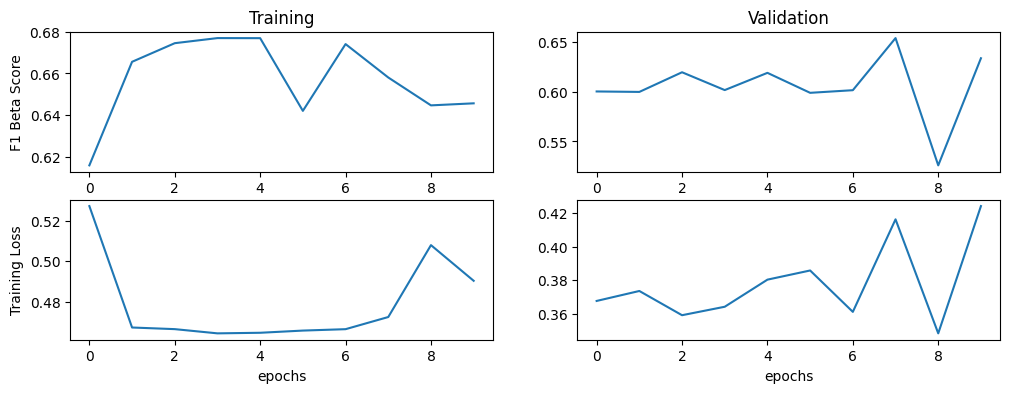

In [346]:
# Plot the training and validation accuracy and loss at each epoch

plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(F1_beta_training)

plt.ylabel('F1 Beta Score')
plt.title('Training')
plt.subplot(2, 2, 2)
plt.plot(F1_beta_validation)
plt.title('Validation')

plt.subplot(2, 2, 3)
plt.plot(mlp_history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2, 2, 4)
plt.plot(mlp_history.history['val_loss'])
plt.xlabel('epochs')

plt.show()

16/16 [==============================] - 0s 9ms/step


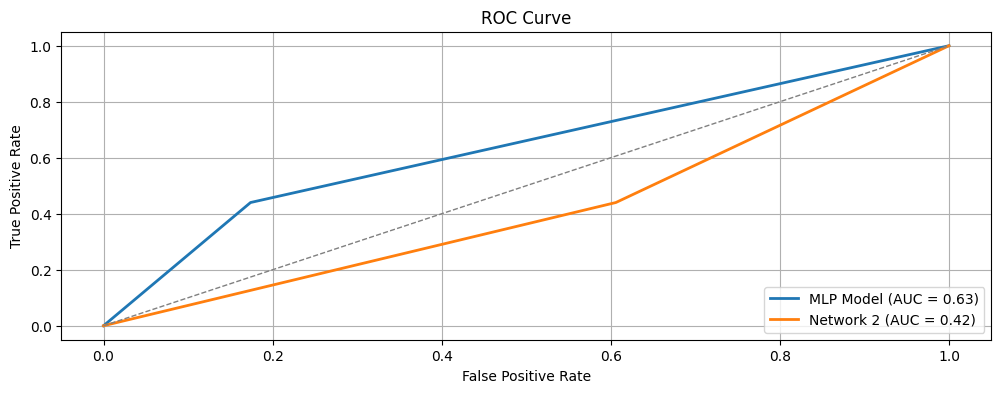

In [295]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for both models
ypred_proba_mlp = training_model_mlp.predict(preprocessed_ds_test_3) >= 0.5
ypred_proba_network2 = training_model_network2.predict(preprocessed_ds_test) >= 0.5

# Convert ds_test to numpy array
y_true = np.concatenate([y for x, y in ds_test.as_numpy_iterator()])

# Compute ROC and AUC for MLP model
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_true, ypred_proba_mlp)
auc_mlp = roc_auc_score(y_true, ypred_proba_mlp)

# Compute ROC and AUC for network 2
fpr_network2, tpr_network2, thresholds_network2 = roc_curve(y_true, ypred_proba_network2)
auc_network2 = roc_auc_score(y_true, ypred_proba_network2)

# Plot ROC curves
plt.figure(figsize=(12, 4))

plt.plot(fpr_mlp, tpr_mlp, label=f'MLP Model (AUC = {auc_mlp:.2f})', linestyle='-', linewidth=2)
plt.plot(fpr_network2, tpr_network2, label=f'Network 2 (AUC = {auc_network2:.2f})', linestyle='-', linewidth=2)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [347]:
# statistical test

mlp_f1 = calculate_F1_beta(mlp_history.history['val_precision'], mlp_history.history['val_recall'], 10)
network2_f1 = calculate_F1_beta(network2_history.history['val_precision'], network2_history.history['val_recall'], 10)

t_stat, p_value = ttest_rel(mlp_f1, network2_f1)

print('MLP F1 beta score:', mlp_f1[-1])
print('Network2 F1 beta score:', network2_f1[-1])
print()

print('T-statistic:', t_stat)
print('P-value:', p_value)

# Interpret the results
alpha = 0.05
if p_value <= alpha:
    print('The models are statistically different. (reject H0)')
else:
    print('There is no significant difference between the models. (fail to reject H0)')


MLP F1 beta score: 0.6338912376788186
Network2 F1 beta score: 0.6597502477196086

T-statistic: -1.2416912418710118
P-value: 0.2457346527427492
There is no significant difference between the models. (fail to reject H0)


In [133]:
from scipy import stats

# Assuming mlp_history and network3_add_history contain the training history of the respective models

# Extract accuracy values from training history
accuracy_mlp = mlp_history.history['accuracy']
accuracy_network3_add = network3_add_history.history['accuracy']

# Perform a paired t-test
t_stat, p_value = stats.ttest_rel(accuracy_mlp, accuracy_network3_add)

print('t_stat', t_stat)
print('p_value', p_value)
# Check the p-value
if p_value < 0.05:
    print("There is a significant difference in accuracy between the models.")
else:
    print("There is no significant difference in accuracy between the models.")


t_stat 0.9595831390238561
p_value 0.36233308550119714
There is no significant difference in accuracy between the models.


### Exceptional Work Capture Embedding Weights

Embedding Layer: gender_embed
Weights: [[0.03439799]]
Embedding Layer: ever_married_embed
Weights: [[0.02744018]]
Embedding Layer: work_type_embed
Weights: [[0.03656734]]
Embedding Layer: Residence_type_embed
Weights: [[0.02870219]]
Embedding Layer: smoking_status_embed
Weights: [[0.04608853]]
Embedding Layer: hypertension_embed
Weights: [[ 0.04339277]
 [-0.04656105]]
Embedding Layer: heart_disease_embed
Weights: [[-0.03046824]
 [ 0.03270081]]


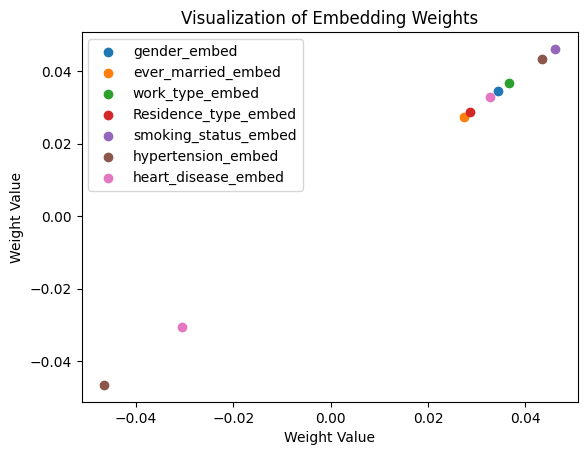

In [374]:
# capture the embedding weights of network2
embedding_weights = []
for layer in training_model_network2.layers:
    if 'embed' in layer.name and 'X' not in layer.name:
        weight = layer.get_weights()[0]
        embedding_weights.append((layer.name, weight))

for name, weights in embedding_weights:
    print(f"Embedding Layer: {name}")
    print(f"Weights: {weights}")


for layer_name, weight in embedding_weights:
    plt.scatter(weight[:, 0], weight[:, 0], label=layer_name)
plt.title('Visualization of Embedding Weights')
plt.xlabel('Weight Value')
plt.ylabel('Weight Value')
plt.legend()
plt.show()